In [1]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import os
import gdown
import zipfile
import scipy as sp
from reservoirpy.nodes import Input, Reservoir, Ridge
from reservoirpy.observables import mse
import pickle
from sklearn.metrics import cohen_kappa_score

## 1. Download Data

In [ ]:
# download dataset
url = "https://drive.google.com/uc?id=1XhCCQ6YrkSe8mdkLaEHYCA6g3ItVMweG"
data_target = "Data"
if not os.path.isfile(data_target):
    gdown.download(url, data_target, quiet=False)

with zipfile.ZipFile(data_target, "r") as zip_file:
    zip_file.extractall("Data")

Parameters

In [144]:
data_path = "data/processed/"
data_labels = ["inputs", "ph_targets", "wd_targets", "pos_targets", "srl_targets"]
dataset = {}
for dl in data_labels:
    with open(data_path+dl+'.pkl', 'rb') as fp:
        data = pickle.load(fp)
    dataset.update({dl: data})


External Inputs

In [3]:
input_data = spio.loadmat(data_path+"inputs.mat", squeeze_me=True)
inputs = [inp.T for inp in input_data['inputs']]

In [4]:
if save:
    with open(clean_data + "inputs.pkl", 'wb') as fp:
        pickle.dump(inputs, fp)

Phonemes

In [5]:
# Phoneme targets
ph_data = spio.loadmat(data_path+"targets_ph.mat", squeeze_me=True)
ph_target_labels = [inp for inp in ph_data['targets_PH']]

# one-hot encoding
Target_indexes = np.array(list(map(int, set(np.concatenate(ph_target_labels)))))-1
I = np.eye(Target_indexes.shape[0])
targets_2 = []
for target in ph_target_labels:
    targets_2.append(np.transpose(I[np.array(list(map(int, target)))-1]))
ph_targets = targets_2

In [6]:
if save:
    with open(clean_data + "ph_targets.pkl", 'wb') as fp:
        pickle.dump(ph_targets, fp)

Words

In [7]:
# Word targets
# note: inputs to the 2nd reservoir are the outputs of the 1st
wd_data = spio.loadmat(data_path+"targets_wd.mat", squeeze_me=True)
wd_targets = [inp for inp in wd_data['targets_WD']]

In [8]:
if save:
    with open(clean_data + "wd_targets.pkl", 'wb') as fp:
        pickle.dump(wd_targets, fp)

Parts-Of-Speech (POS)

In [9]:
# POS tags
# note: inputs to the 3rd reservoir are the outputs of the 2nd
pos_dataset = spio.loadmat(data_path+'targets_pos.mat', squeeze_me=True)
pos_targets = [inp for inp in pos_dataset['targets']]

In [10]:
if save:
    with open(clean_data + "pos_targets.pkl", 'wb') as fp:
        pickle.dump(pos_targets, fp)

SRL

In [11]:
# SRL tags
# note: inputs to the 4th reservoir are the outputs of the 3rd
N_verbs = 6
N_targets = 27
srl_targets = []
for i in range(N_verbs):
    dataset = spio.loadmat(data_path+'targets'+str(i)+'_srl', squeeze_me=True)
    # one-hot encoding
    tar = dataset['targets'+str(i)]
    #Target_indexes = np.array(list(map(int, set(np.concatenate(tar)))))-1
    I = np.eye(N_targets)
    targets_2 = []
    for target in tar:
        targets_2.append(np.transpose(I[np.array(list(map(int, target)))-1]))
    tar = targets_2
    srl_targets.append(tar)

In [12]:
if save:
    with open(clean_data + "srl_targets.pkl", 'wb') as fp:
        pickle.dump(srl_targets, fp)

## 2. Preprocess

In [2]:
# Load and preprocess dataset
data_path = "Data/Processed/"
data_labels = ["inputs", "ph_targets", "wd_targets", "pos_targets", "srl_targets"]
dataset = {}
for dl in data_labels:
    with open(data_path+dl+'.pkl', 'rb') as fp:
        data = pickle.load(fp)
    dataset.update({dl: data})

In [3]:
# Split dataset
train, test = int(0.7 * len(dataset['inputs'])), int(0.3 * len(dataset['inputs']))

train_data = dataset['inputs'][:train]
train_target1 = dataset["ph_targets"][:train]
train_target2 = dataset["wd_targets"][:train]
train_target3 = dataset["pos_targets"][:train]

test_data = dataset['inputs'][train:]
test_target1 = dataset["ph_targets"][train:]
test_target2 = dataset["wd_targets"][train:]
test_target3 = dataset["pos_targets"][train:]

print(len(train_target1))
print(len(test_target1))
print(len(test_target1[1]))

4410
1890
52


## 3. Analysis

Mean temporal ratio (words / phonemes): 6.779254416271836 ms


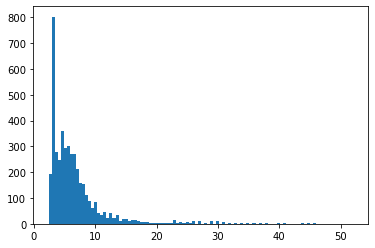

In [15]:
ratios = []
for ph, wd in zip(train_target1, train_target2):
    ph_duration = np.mean(np.diff(np.nonzero(np.diff(np.argmax(ph, axis=0)))[0]))
    wd_duration = np.mean(np.diff(np.nonzero(np.diff(np.argmax(wd, axis=0)))[0]))
    ratios.append(wd_duration / ph_duration)

plt.hist(ratios, 100)
print("Mean temporal ratio (words / phonemes): {} ms".format(np.mean(ratios)))

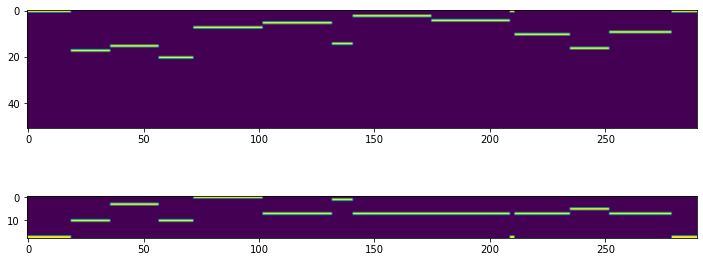

In [16]:
# Temporal relation between words and pos tags
fig, ax = plt.subplots(2, figsize=(12, 5))
ax[0].imshow(train_target2[0])
ax[1].imshow(train_target3[0])

Mean temporal ratio (POS / words): 0.7789491893918294 ms


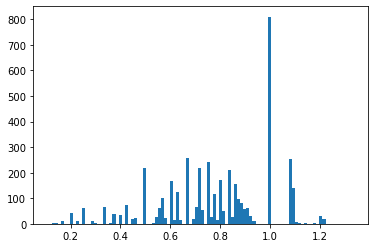

In [17]:
ratios = []
for wd, pos in zip(train_target2, train_target3):
    wd_duration = np.mean(np.diff(np.nonzero(np.diff(np.argmax(wd, axis=0)))[0]))
    pos_duration = np.mean(np.diff(np.nonzero(np.diff(np.argmax(pos, axis=0)))[0]))
    ratios.append(pos_duration / wd_duration)

plt.hist(ratios, 100)
print("Mean temporal ratio (POS / words): {} ms".format(np.mean(ratios)))

## 4. HTR system Analysis

In [4]:
def define_network(lr):
    # System parameters
    n_in1 = train_data[0].shape[1]
    n_out1 = train_target1[0].shape[1]
    n_in2 = n_out1
    n_out2 = train_target2[0].shape[1]
    n_in3 = n_out2
    n_out3 = train_target3[0].shape[1]

    n_layers = 3
    N = 100
    n_inputs = [n_in1, n_in2, n_in3]

    # parameters according to the paper
    leakage_rates = [lr, lr, lr]
    spectral_radius = [0.8616, 1.1786, 1.2298]
    input_scaling = [0.7721, 8.8463, 2.6722]
    regularization_terms = [6.56e-3, 4.59e-5, 1.49e-5]
    rec_density = 0.01



    layers = []
    readouts = []
    sub_systems = []

    for layer in range(n_layers):
        Win = np.random.rand(N, n_inputs[layer]+1) - 0.5

        W = np.random.rand(N, N) - 0.5
        mask = np.random.rand(N, N)
        W[mask > rec_density] = 0

        Win = (Win / np.linalg.norm(Win, 2)) * input_scaling[layer]
        original_spectral_radius = np.max(np.real(np.linalg.eigvals(W)))
        W *= (spectral_radius[layer] / original_spectral_radius)
        W = sp.sparse.csr_matrix(W)

        inputs = Input(n_inputs[layer])
        reservoir = Reservoir(N, lr=leakage_rates[layer], sr=spectral_radius[layer], input_bias=True,
                              input_scaling=input_scaling[layer], W=W, Win=Win)
        readout = Ridge(ridge=regularization_terms[layer])

        system = inputs >> reservoir >> readout
        layers.append(reservoir)
        readouts.append(readout)
        sub_systems.append(system)
    
    return sub_systems

#### 4.1.1 Train Phonemes

In [5]:
def train_network_0(sub_systems):
    train_target = [x.T for x in train_target1]
    sub_systems[0].fit(train_data, train_target)

#### 4.1.2 Predict Phonemes

In [20]:
test_pred1 = sub_systems[0].run(test_data[0])
print("\nMSE = {}".format(mse(test_pred1, test_target1[0].T)))

NameError: name 'sub_systems' is not defined

Text(0.5, 1.0, 'Predicted')

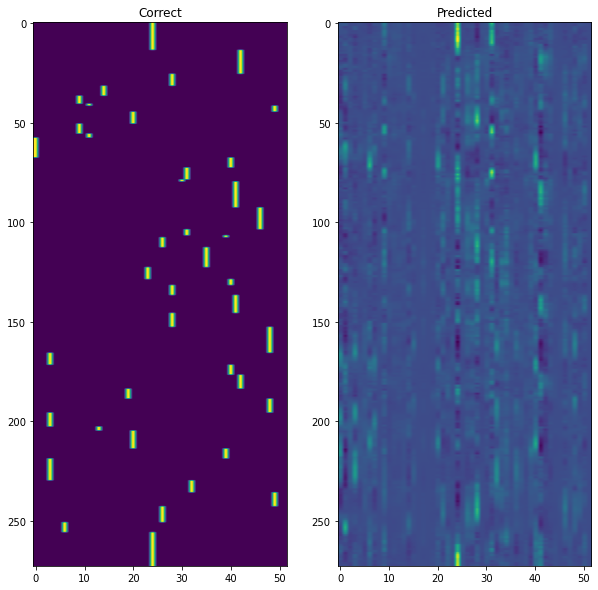

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(test_target1[0].T, aspect='auto')
ax[1].imshow(test_pred1, aspect='auto')
ax[0].set_title("Correct")
ax[1].set_title("Predicted")

In [13]:
# kappa-score
labels_target1 = np.argmax(test_target1[0], axis=1)
labels_predicted1 = np.argmax(test_pred1, axis=0)
labels_predicted1, labels_target1

(array([215, 253, 202, 226,  64, 189,  71, 201,  78,  74,  17,  56,   7,
        152,  61, 161, 120, 120, 120, 187,  72, 246, 263,  79,   8, 263,
         49, 103,  49,  17,  79,  75, 229, 120, 120, 131, 226, 229,  79,
        214,  70,  85,  17,  18, 264, 159, 243, 258, 161, 244,  84, 106],
       dtype=int64),
 array([ 58,   0,   0, 166,   0,   0, 251,   0,   0,  37,   0,  41,   0,
        203,  32,   0,   0,   0,   0, 184,  45,   0,   0, 123,   0,   0,
        108,   0,  26,   0,  79,  73, 230,   0,   0, 113,   0,   0,   0,
        107,  68,  80,  14,   0,   0,   0,  93,   0, 153,  42,   0,   0],
       dtype=int64))

In [14]:
cohen_kappa_score(labels_target1, labels_predicted1)

0.01814142910033323

In [6]:
def calculate_accuracy(sub_systems):
    predictions = []
    mse_total = 0
    kappa_total = 0

    for i in range(len(test_data)):
        pred = sub_systems[0].run(test_data[i])
        predictions.append(pred)
    for i in range (len(predictions)):
        mse_total += mse(predictions[i], test_target1[i].T)
        labels_target1 = np.argmax(test_target1[i], axis=1)
        labels_predicted1 = np.argmax(predictions[i], axis=0)
        kappa_total += cohen_kappa_score(labels_target1, labels_predicted1)
    return mse_total, kappa_total

In [7]:
# lr = 0
# mse_results = []
# kappa_results = []
# for i in range (10):
lr = 0.1
sub_systems = define_network(lr)
train_network_0(sub_systems)
# results = calculate_accuracy(sub_systems)
#     mse_results.append(results[0])
#     kappa_results.append(results[1])
# print(mse_results)
# print(kappa_results)

# plt.plot(lr_values, mse_results)
# plt.title("Total Mean Squared Error per Leakage Rate")
# plt.xlabel("Leakage rate")
# plt.ylabel("Total Mean Squared Error")
# plt.xticks(lr_values)
# plt.show()

# plt.plot(lr_values, kappa_results)
# plt.title("Total Cohen-Kappa Score per Leakage Rate")
# plt.xlabel("Leakage rate")
# plt.ylabel("Total Cohen-Kappa Score")
# plt.xticks(lr_values)
# plt.show()

<ipython-input-4-e585806098d7>:36: RuntimeWarning: divide by zero encountered in double_scalars
  W *= (spectral_radius[layer] / original_spectral_radius)
<ipython-input-4-e585806098d7>:36: RuntimeWarning: invalid value encountered in multiply
  W *= (spectral_radius[layer] / original_spectral_radius)
Running Model-1:   0%|                                                                        | 0/4410 [00:00<?, ?it/s]
Running Model-1: 290it [00:00, 5308.02it/s]                                                                            

Running Model-1: 214it [00:00, 5944.36it/s]                                                                            
Running Model-1:   0%|                                                                | 2/4410 [00:00<03:41, 19.87it/s]
Running Model-1: 307it [00:00, 5581.42it/s]                                                                            

Running Model-1: 282it [00:00, 5528.44it/s]                                                    

Running Model-1: 346it [00:00, 5864.43it/s]                                                                            
Running Model-1:   1%|▋                                                              | 45/4410 [00:02<04:24, 16.49it/s]
Running Model-1: 222it [00:00, 5550.01it/s]                                                                            

Running Model-1: 262it [00:00, 6093.46it/s]                                                                            

Running Model-1: 317it [00:00, 5560.20it/s]                                                                            
Running Model-1:   1%|▋                                                              | 48/4410 [00:02<04:11, 17.37it/s]
Running Model-1: 341it [00:00, 6315.47it/s]                                                                            

Running Model-1: 266it [00:00, 5782.64it/s]                                                                            
Running Model-1:   1%|▋              

Running Model-1: 262it [00:00, 5458.40it/s]                                                                            

Running Model-1: 264it [00:00, 5499.96it/s]                                                                            
Running Model-1:   2%|█▎                                                             | 90/4410 [00:05<04:25, 16.26it/s]
Running Model-1: 324it [00:00, 5491.66it/s]                                                                            

Running Model-1: 287it [00:00, 5979.10it/s]                                                                            
Running Model-1:   2%|█▎                                                             | 92/4410 [00:05<04:22, 16.42it/s]
Running Model-1: 310it [00:00, 5719.82it/s]                                                                            

Running Model-1: 197it [00:00, 5384.50it/s]                                                                            
Running Model-1:   2%|█▎             

Running Model-1:   3%|█▉                                                            | 134/4410 [00:07<03:55, 18.17it/s]
Running Model-1: 428it [00:00, 6584.83it/s]                                                                            

Running Model-1: 199it [00:00, 5378.98it/s]                                                                            
Running Model-1:   3%|█▉                                                            | 136/4410 [00:08<03:57, 17.99it/s]
Running Model-1: 298it [00:00, 6206.66it/s]                                                                            

Running Model-1: 205it [00:00, 5857.21it/s]                                                                            

Running Model-1: 225it [00:00, 6039.02it/s]                                                                            
Running Model-1:   3%|█▉                                                            | 139/4410 [00:08<03:42, 19.22it/s]
Running Model-1: 202it [00:00, 5611.2

Running Model-1: 254it [00:00, 5772.71it/s]                                                                            
Running Model-1:   4%|██▌                                                           | 181/4410 [00:10<03:35, 19.61it/s]
Running Model-1: 284it [00:00, 5796.00it/s]                                                                            

Running Model-1: 237it [00:00, 5646.18it/s]                                                                            
Running Model-1:   4%|██▌                                                           | 183/4410 [00:10<03:36, 19.52it/s]
Running Model-1: 274it [00:00, 5708.29it/s]                                                                            

Running Model-1: 383it [00:00, 6491.63it/s]                                                                            
Running Model-1:   4%|██▌                                                           | 185/4410 [00:10<03:45, 18.74it/s]
Running Model-1: 249it [00:00, 5302.40

Running Model-1: 255it [00:00, 5204.08it/s]                                                                            
Running Model-1:   5%|███▏                                                          | 226/4410 [00:13<03:50, 18.16it/s]
Running Model-1: 307it [00:00, 5572.44it/s]                                                                            

Running Model-1: 460it [00:00, 6572.20it/s]                                                                            
Running Model-1:   5%|███▏                                                          | 228/4410 [00:13<04:06, 16.95it/s]
Running Model-1: 297it [00:00, 5823.62it/s]                                                                            

Running Model-1: 345it [00:00, 5948.29it/s]                                                                            
Running Model-1:   5%|███▏                                                          | 230/4410 [00:13<04:07, 16.91it/s]
Running Model-1: 340it [00:00, 5762.83

Running Model-1:   6%|███▊                                                          | 271/4410 [00:15<03:40, 18.77it/s]
Running Model-1: 225it [00:00, 5625.07it/s]                                                                            

Running Model-1: 233it [00:00, 5547.77it/s]                                                                            

Running Model-1: 242it [00:00, 6368.48it/s]                                                                            
Running Model-1:   6%|███▊                                                          | 274/4410 [00:15<03:29, 19.78it/s]
Running Model-1: 207it [00:00, 5447.63it/s]                                                                            

Running Model-1: 289it [00:00, 5557.89it/s]                                                                            
Running Model-1:   6%|███▉                                                          | 276/4410 [00:15<03:28, 19.78it/s]
Running Model-1: 184it [00:00, 5411.6

Running Model-1: 388it [00:00, 6689.51it/s]                                                                            
Running Model-1:   7%|████▍                                                         | 317/4410 [00:18<04:10, 16.33it/s]
Running Model-1: 390it [00:00, 6000.28it/s]                                                                            

Running Model-1: 308it [00:00, 6160.12it/s]                                                                            
Running Model-1:   7%|████▍                                                         | 319/4410 [00:18<04:14, 16.08it/s]
Running Model-1: 310it [00:00, 4428.49it/s]                                                                            

Running Model-1: 305it [00:00, 6100.27it/s]                                                                            
Running Model-1:   7%|████▌                                                         | 321/4410 [00:18<04:26, 15.36it/s]
Running Model-1: 226it [00:00, 5443.33

Running Model-1:   8%|█████                                                         | 361/4410 [00:21<03:55, 17.16it/s]
Running Model-1: 305it [00:00, 5258.66it/s]                                                                            

Running Model-1: 318it [00:00, 4851.30it/s]                                                                            
Running Model-1:   8%|█████                                                         | 363/4410 [00:21<04:07, 16.35it/s]
Running Model-1: 116it [00:00, 5524.15it/s]                                                                            

Running Model-1: 231it [00:00, 5500.12it/s]                                                                            

Running Model-1: 234it [00:00, 5445.24it/s]                                                                            
Running Model-1:   8%|█████▏                                                        | 366/4410 [00:21<03:33, 18.91it/s]
Running Model-1: 207it [00:00, 5750.3

Running Model-1: 321it [00:00, 5732.24it/s]                                                                            

Running Model-1: 317it [00:00, 6340.10it/s]                                                                            
Running Model-1:   9%|█████▋                                                        | 408/4410 [00:23<03:43, 17.92it/s]
Running Model-1: 254it [00:00, 5907.18it/s]                                                                            

Running Model-1: 253it [00:00, 5883.82it/s]                                                                            

Running Model-1: 326it [00:00, 5923.41it/s]                                                                            
Running Model-1:   9%|█████▊                                                        | 411/4410 [00:23<03:39, 18.25it/s]
Running Model-1: 276it [00:00, 5750.05it/s]                                                                            

Running Model-1: 251it [00:00, 5704.

Running Model-1: 249it [00:00, 5658.37it/s]                                                                            

Running Model-1: 202it [00:00, 5947.86it/s]                                                                            

Running Model-1: 135it [00:00, 5476.97it/s]                                                                            
Running Model-1:  10%|██████▍                                                       | 454/4410 [00:26<03:29, 18.85it/s]
Running Model-1: 376it [00:00, 6064.49it/s]                                                                            

Running Model-1: 326it [00:00, 5821.38it/s]                                                                            
Running Model-1:  10%|██████▍                                                       | 456/4410 [00:26<03:41, 17.84it/s]
Running Model-1: 299it [00:00, 6102.07it/s]                                                                            

Running Model-1: 263it [00:00, 5595.

Running Model-1: 353it [00:00, 6671.61it/s]                                                                            
Running Model-1:  11%|███████                                                       | 498/4410 [00:28<03:51, 16.86it/s]
Running Model-1: 372it [00:00, 6526.65it/s]                                                                            

Running Model-1: 388it [00:00, 6807.17it/s]                                                                            
Running Model-1:  11%|███████                                                       | 500/4410 [00:29<03:56, 16.53it/s]
Running Model-1: 292it [00:00, 5407.66it/s]                                                                            

Running Model-1: 226it [00:00, 5650.17it/s]                                                                            
Running Model-1:  11%|███████                                                       | 502/4410 [00:29<03:47, 17.15it/s]
Running Model-1: 196it [00:00, 6125.22

Running Model-1: 390it [00:00, 6093.94it/s]                                                                            
Running Model-1:  12%|███████▋                                                      | 543/4410 [00:31<03:53, 16.59it/s]
Running Model-1: 337it [00:00, 5810.38it/s]                                                                            

Running Model-1: 321it [00:00, 5836.38it/s]                                                                            
Running Model-1:  12%|███████▋                                                      | 545/4410 [00:31<03:54, 16.45it/s]
Running Model-1: 209it [00:00, 5648.80it/s]                                                                            

Running Model-1: 286it [00:00, 5836.70it/s]                                                                            

Running Model-1: 383it [00:00, 6177.56it/s]                                                                            
Running Model-1:  12%|███████▋       

Running Model-1: 333it [00:00, 5741.35it/s]                                                                            
Running Model-1:  13%|████████▎                                                     | 588/4410 [00:34<03:40, 17.34it/s]
Running Model-1: 323it [00:00, 5870.89it/s]                                                                            

Running Model-1: 276it [00:00, 5750.10it/s]                                                                            
Running Model-1:  13%|████████▎                                                     | 590/4410 [00:34<03:39, 17.40it/s]
Running Model-1: 365it [00:00, 6083.36it/s]                                                                            

Running Model-1: 271it [00:00, 6305.19it/s]                                                                            
Running Model-1:  13%|████████▎                                                     | 592/4410 [00:34<03:39, 17.40it/s]
Running Model-1: 143it [00:00, 5097.53

Running Model-1: 326it [00:00, 5525.42it/s]                                                                            

Running Model-1: 418it [00:00, 6634.95it/s]                                                                            
Running Model-1:  14%|████████▉                                                     | 634/4410 [00:36<03:47, 16.60it/s]
Running Model-1: 524it [00:00, 6238.46it/s]                                                                            

Running Model-1: 284it [00:00, 6173.94it/s]                                                                            
Running Model-1:  14%|████████▉                                                     | 636/4410 [00:36<03:58, 15.83it/s]
Running Model-1: 315it [00:00, 5833.42it/s]                                                                            

Running Model-1: 458it [00:00, 6939.45it/s]                                                                            
Running Model-1:  14%|████████▉      

Running Model-1: 321it [00:00, 5836.43it/s]                                                                            
Running Model-1:  15%|█████████▌                                                    | 678/4410 [00:39<04:00, 15.54it/s]
Running Model-1: 436it [00:00, 6002.11it/s]                                                                            

Running Model-1: 251it [00:00, 5899.36it/s]                                                                            
Running Model-1:  15%|█████████▌                                                    | 680/4410 [00:39<03:59, 15.61it/s]
Running Model-1: 305it [00:00, 5865.46it/s]                                                                            

Running Model-1: 250it [00:00, 5610.51it/s]                                                                            
Running Model-1:  15%|█████████▌                                                    | 682/4410 [00:39<03:47, 16.35it/s]
Running Model-1: 155it [00:00, 5723.11

Running Model-1: 366it [00:00, 5630.83it/s]                                                                            

Running Model-1: 146it [00:00, 5214.49it/s]                                                                            
Running Model-1:  16%|██████████▏                                                   | 725/4410 [00:41<03:15, 18.87it/s]
Running Model-1: 255it [00:00, 5543.51it/s]                                                                            

Running Model-1: 221it [00:00, 5245.67it/s]                                                                            
Running Model-1:  16%|██████████▏                                                   | 727/4410 [00:42<03:12, 19.12it/s]
Running Model-1: 266it [00:00, 5524.23it/s]                                                                            

Running Model-1: 321it [00:00, 6058.19it/s]                                                                            
Running Model-1:  17%|██████████▏    

Running Model-1: 374it [00:00, 5753.88it/s]                                                                            

Running Model-1: 294it [00:00, 5764.77it/s]                                                                            
Running Model-1:  17%|██████████▊                                                   | 770/4410 [00:44<03:42, 16.33it/s]
Running Model-1: 447it [00:00, 5883.15it/s]                                                                            

Running Model-1: 347it [00:00, 5825.38it/s]                                                                            
Running Model-1:  18%|██████████▊                                                   | 772/4410 [00:44<03:56, 15.36it/s]
Running Model-1: 623it [00:00, 6564.89it/s]                                                                            

Running Model-1: 207it [00:00, 5750.57it/s]                                                                            
Running Model-1:   0%|               

Running Model-1: 97it [00:00, 5104.99it/s]                                                                             

Running Model-1: 443it [00:00, 5829.04it/s]                                                                            
Running Model-1:  18%|███████████▍                                                  | 815/4410 [00:47<03:09, 18.97it/s]
Running Model-1: 230it [00:00, 5750.52it/s]                                                                            

Running Model-1: 253it [00:00, 5383.04it/s]                                                                            

Running Model-1: 251it [00:00, 5577.92it/s]                                                                            
Running Model-1:  19%|███████████▌                                                  | 818/4410 [00:47<03:05, 19.40it/s]
Running Model-1: 289it [00:00, 5898.07it/s]                                                                            

Running Model-1: 293it [00:00, 5860.

Running Model-1: 209it [00:00, 5860.20it/s]                                                                            
Running Model-1:  20%|████████████                                                  | 860/4410 [00:49<02:59, 19.76it/s]
Running Model-1: 319it [00:00, 5683.48it/s]                                                                            

Running Model-1: 247it [00:00, 5255.67it/s]                                                                            
Running Model-1:  20%|████████████                                                  | 862/4410 [00:49<03:05, 19.10it/s]
Running Model-1: 250it [00:00, 5814.21it/s]                                                                            

Running Model-1: 444it [00:00, 6224.83it/s]                                                                            
Running Model-1:  20%|████████████▏                                                 | 864/4410 [00:49<03:16, 18.07it/s]
Running Model-1: 291it [00:00, 5706.14

Running Model-1: 195it [00:00, 5571.57it/s]                                                                            

Running Model-1: 299it [00:00, 5339.20it/s]                                                                            
Running Model-1:  21%|████████████▋                                                 | 906/4410 [00:52<03:05, 18.88it/s]
Running Model-1: 194it [00:00, 5542.99it/s]                                                                            

Running Model-1: 254it [00:00, 5772.86it/s]                                                                            

Running Model-1: 235it [00:00, 5465.12it/s]                                                                            
Running Model-1:  21%|████████████▊                                                 | 909/4410 [00:52<02:56, 19.81it/s]
Running Model-1: 229it [00:00, 5725.45it/s]                                                                            

Running Model-1: 276it [00:00, 5872.

Running Model-1: 313it [00:00, 5735.83it/s]                                                                            

Running Model-1: 254it [00:00, 5080.15it/s]                                                                            
Running Model-1:  22%|█████████████▍                                                | 952/4410 [00:54<03:29, 16.48it/s]
Running Model-1: 242it [00:00, 4867.07it/s]                                                                            

Running Model-1: 428it [00:00, 6294.40it/s]                                                                            
Running Model-1:  22%|█████████████▍                                                | 954/4410 [00:55<03:35, 16.07it/s]
Running Model-1: 203it [00:00, 5275.63it/s]                                                                            

Running Model-1: 252it [00:00, 5478.40it/s]                                                                            

Running Model-1: 275it [00:00, 5851.

Running Model-1: 231it [00:00, 6079.12it/s]                                                                            

Running Model-1: 254it [00:00, 5907.04it/s]                                                                            

Running Model-1: 347it [00:00, 5783.50it/s]                                                                            
Running Model-1:  23%|██████████████                                                | 999/4410 [00:57<03:04, 18.44it/s]
Running Model-1: 221it [00:00, 5666.77it/s]                                                                            

Running Model-1: 357it [00:00, 6263.22it/s]                                                                            
Running Model-1:  23%|█████████████▊                                               | 1001/4410 [00:57<03:05, 18.42it/s]
Running Model-1: 253it [00:00, 5622.30it/s]                                                                            

Running Model-1: 472it [00:00, 5900.

Running Model-1: 260it [00:00, 5000.18it/s]                                                                            

Running Model-1: 314it [00:00, 6238.30it/s]                                                                            
Running Model-1:  24%|██████████████▍                                              | 1043/4410 [01:00<03:22, 16.63it/s]
Running Model-1: 189it [00:00, 5400.10it/s]                                                                            

Running Model-1: 411it [00:00, 6523.89it/s]                                                                            
Running Model-1:  24%|██████████████▍                                              | 1045/4410 [01:00<03:17, 17.06it/s]
Running Model-1: 324it [00:00, 5586.24it/s]                                                                            

Running Model-1: 244it [00:00, 5951.27it/s]                                                                            
Running Model-1:  24%|██████████████▍

Running Model-1:  25%|███████████████                                              | 1088/4410 [01:02<03:22, 16.38it/s]
Running Model-1: 371it [00:00, 5888.85it/s]                                                                            

Running Model-1: 230it [00:00, 5609.80it/s]                                                                            
Running Model-1:  25%|███████████████                                              | 1090/4410 [01:02<03:19, 16.68it/s]
Running Model-1: 364it [00:00, 5687.81it/s]                                                                            

Running Model-1: 277it [00:00, 6442.11it/s]                                                                            
Running Model-1:  25%|███████████████                                              | 1092/4410 [01:02<03:19, 16.64it/s]
Running Model-1: 140it [00:00, 5833.93it/s]                                                                            

Running Model-1: 300it [00:00, 5555.6

Running Model-1: 189it [00:00, 5400.13it/s]                                                                            
Running Model-1:  26%|███████████████▋                                             | 1134/4410 [01:05<03:04, 17.80it/s]
Running Model-1: 354it [00:00, 5619.14it/s]                                                                            

Running Model-1: 366it [00:00, 6421.09it/s]                                                                            
Running Model-1:  26%|███████████████▋                                             | 1136/4410 [01:05<03:13, 16.95it/s]
Running Model-1: 265it [00:00, 6162.93it/s]                                                                            

Running Model-1: 319it [00:00, 5800.29it/s]                                                                            
Running Model-1:  26%|███████████████▋                                             | 1138/4410 [01:05<03:08, 17.33it/s]
Running Model-1: 273it [00:00, 5808.73

Running Model-1:  27%|████████████████▎                                            | 1179/4410 [01:07<02:46, 19.35it/s]
Running Model-1: 313it [00:00, 5905.64it/s]                                                                            

Running Model-1: 373it [00:00, 7037.74it/s]                                                                            
Running Model-1:  27%|████████████████▎                                            | 1181/4410 [01:07<02:52, 18.69it/s]
Running Model-1: 317it [00:00, 5763.68it/s]                                                                            

Running Model-1: 241it [00:00, 5738.09it/s]                                                                            
Running Model-1:  27%|████████████████▎                                            | 1183/4410 [01:07<02:53, 18.64it/s]
Running Model-1: 310it [00:00, 5849.03it/s]                                                                            

Running Model-1: 415it [00:00, 6805.3

Running Model-1:  28%|████████████████▉                                            | 1224/4410 [01:10<03:09, 16.78it/s]
Running Model-1: 179it [00:00, 5594.16it/s]                                                                            

Running Model-1: 315it [00:00, 5833.34it/s]                                                                            

Running Model-1: 246it [00:00, 6307.84it/s]                                                                            
Running Model-1:  28%|████████████████▉                                            | 1227/4410 [01:10<02:56, 18.07it/s]
Running Model-1: 359it [00:00, 5890.65it/s]                                                                            

Running Model-1: 376it [00:00, 5612.01it/s]                                                                            
Running Model-1:  28%|████████████████▉                                            | 1229/4410 [01:10<03:07, 16.94it/s]
Running Model-1: 279it [00:00, 5694.0

Running Model-1: 205it [00:00, 5256.53it/s]                                                                            

Running Model-1: 329it [00:00, 6326.95it/s]                                                                            
Running Model-1:  29%|█████████████████▌                                           | 1271/4410 [01:12<03:04, 17.06it/s]
Running Model-1: 297it [00:00, 5507.99it/s]                                                                            

Running Model-1: 234it [00:00, 5571.48it/s]                                                                            
Running Model-1:  29%|█████████████████▌                                           | 1273/4410 [01:13<02:59, 17.50it/s]
Running Model-1: 200it [00:00, 5555.81it/s]                                                                            

Running Model-1: 429it [00:00, 6600.19it/s]                                                                            
Running Model-1:  29%|███████████████

Running Model-1: 257it [00:00, 5976.05it/s]                                                                            
Running Model-1:  30%|██████████████████▏                                          | 1315/4410 [01:15<03:08, 16.41it/s]
Running Model-1: 271it [00:00, 5645.96it/s]                                                                            

Running Model-1: 220it [00:00, 5641.30it/s]                                                                            
Running Model-1:  30%|██████████████████▏                                          | 1317/4410 [01:15<02:58, 17.34it/s]
Running Model-1: 355it [00:00, 6339.37it/s]                                                                            

Running Model-1: 330it [00:00, 5689.76it/s]                                                                            
Running Model-1:  30%|██████████████████▏                                          | 1319/4410 [01:15<03:03, 16.83it/s]
Running Model-1: 335it [00:00, 6700.17

Running Model-1: 260it [00:00, 5777.86it/s]                                                                            

Running Model-1: 245it [00:00, 5568.22it/s]                                                                            
Running Model-1:  31%|██████████████████▊                                          | 1360/4410 [01:18<03:02, 16.73it/s]
Running Model-1: 251it [00:00, 5456.72it/s]                                                                            

Running Model-1: 200it [00:00, 5405.45it/s]                                                                            

Running Model-1: 214it [00:00, 5631.67it/s]                                                                            
Running Model-1:  31%|██████████████████▊                                          | 1363/4410 [01:18<02:45, 18.41it/s]
Running Model-1: 296it [00:00, 5804.10it/s]                                                                            

Running Model-1: 203it [00:00, 5342.

Running Model-1:  32%|███████████████████▍                                         | 1406/4410 [01:20<02:44, 18.24it/s]
Running Model-1: 328it [00:00, 5754.44it/s]                                                                            

Running Model-1: 266it [00:00, 5541.77it/s]                                                                            
Running Model-1:  32%|███████████████████▍                                         | 1408/4410 [01:20<02:47, 17.90it/s]
Running Model-1: 273it [00:00, 5808.52it/s]                                                                            

Running Model-1: 306it [00:00, 6120.09it/s]                                                                            
Running Model-1:  32%|███████████████████▌                                         | 1410/4410 [01:20<02:46, 18.06it/s]
Running Model-1: 305it [00:00, 5980.43it/s]                                                                            

Running Model-1: 222it [00:00, 5981.9

Running Model-1: 243it [00:00, 5404.14it/s]                                                                            

Running Model-1: 492it [00:00, 6473.79it/s]                                                                            
Running Model-1:  33%|████████████████████                                         | 1453/4410 [01:23<02:44, 17.92it/s]
Running Model-1: 271it [00:00, 5646.07it/s]                                                                            

Running Model-1: 238it [00:00, 5666.95it/s]                                                                            
Running Model-1:  33%|████████████████████▏                                        | 1455/4410 [01:23<02:41, 18.35it/s]
Running Model-1: 266it [00:00, 5541.68it/s]                                                                            

Running Model-1: 259it [00:00, 5510.65it/s]                                                                            
Running Model-1:  33%|███████████████

Running Model-1: 323it [00:00, 5666.79it/s]                                                                            
Running Model-1:  34%|████████████████████▋                                        | 1498/4410 [01:25<03:01, 16.02it/s]
Running Model-1: 403it [00:00, 6716.70it/s]                                                                            

Running Model-1: 107it [00:00, 5353.39it/s]                                                                            

Running Model-1: 328it [00:00, 6074.30it/s]                                                                            
Running Model-1:  34%|████████████████████▊                                        | 1501/4410 [01:26<02:48, 17.25it/s]
Running Model-1: 259it [00:00, 5114.07it/s]                                                                            

Running Model-1: 509it [00:00, 6059.72it/s]                                                                            
Running Model-1:  34%|███████████████

Running Model-1: 297it [00:00, 6319.06it/s]                                                                            
Running Model-1:  35%|█████████████████████▎                                       | 1544/4410 [01:28<02:46, 17.24it/s]
Running Model-1: 288it [00:00, 5877.46it/s]                                                                            

Running Model-1: 369it [00:00, 6150.23it/s]                                                                            
Running Model-1:  35%|█████████████████████▍                                       | 1546/4410 [01:28<02:48, 16.98it/s]
Running Model-1: 374it [00:00, 5751.27it/s]                                                                            

Running Model-1: 258it [00:00, 5733.41it/s]                                                                            
Running Model-1:  35%|█████████████████████▍                                       | 1548/4410 [01:28<02:49, 16.84it/s]
Running Model-1: 290it [00:00, 5686.50

Running Model-1:  36%|█████████████████████▉                                       | 1589/4410 [01:30<02:29, 18.82it/s]
Running Model-1: 194it [00:00, 5542.92it/s]                                                                            

Running Model-1: 319it [00:00, 5597.34it/s]                                                                            
Running Model-1:  36%|██████████████████████                                       | 1591/4410 [01:30<02:28, 18.93it/s]
Running Model-1: 210it [00:00, 5526.51it/s]                                                                            

Running Model-1: 122it [00:00, 5304.51it/s]                                                                            

Running Model-1: 233it [00:00, 5597.11it/s]                                                                            
Running Model-1:  36%|██████████████████████                                       | 1594/4410 [01:31<02:15, 20.76it/s]
Running Model-1: 323it [00:00, 5629.7

Running Model-1: 278it [00:00, 5338.07it/s]                                                                            

Running Model-1: 291it [00:00, 5705.90it/s]                                                                            
Running Model-1:  37%|██████████████████████▋                                      | 1636/4410 [01:33<02:39, 17.42it/s]
Running Model-1: 324it [00:00, 5998.02it/s]                                                                            

Running Model-1: 223it [00:00, 5713.54it/s]                                                                            
Running Model-1:  37%|██████████████████████▋                                      | 1638/4410 [01:33<02:35, 17.86it/s]
Running Model-1: 277it [00:00, 5653.31it/s]                                                                            

Running Model-1: 247it [00:00, 5676.49it/s]                                                                            
Running Model-1:  37%|███████████████

Running Model-1:  38%|███████████████████████▏                                     | 1680/4410 [01:35<02:20, 19.47it/s]
Running Model-1: 400it [00:00, 6557.37it/s]                                                                            

Running Model-1: 270it [00:00, 5510.15it/s]                                                                            
Running Model-1:  38%|███████████████████████▎                                     | 1682/4410 [01:35<02:26, 18.58it/s]
Running Model-1: 363it [00:00, 6482.31it/s]                                                                            

Running Model-1: 490it [00:00, 6377.84it/s]                                                                            
Running Model-1:  38%|███████████████████████▎                                     | 1684/4410 [01:36<02:40, 16.94it/s]
Running Model-1: 225it [00:00, 5113.70it/s]                                                                            

Running Model-1: 536it [00:00, 6448.7

Running Model-1: 550it [00:00, 6626.72it/s]                                                                            

Running Model-1: 449it [00:00, 6701.53it/s]                                                                            
Running Model-1:  39%|███████████████████████▊                                     | 1726/4410 [01:38<02:51, 15.61it/s]
Running Model-1: 248it [00:00, 5767.54it/s]                                                                            

Running Model-1: 367it [00:00, 5825.42it/s]                                                                            
Running Model-1:  39%|███████████████████████▉                                     | 1728/4410 [01:38<02:48, 15.95it/s]
Running Model-1: 284it [00:00, 5680.06it/s]                                                                            

Running Model-1: 255it [00:00, 5795.53it/s]                                                                            
Running Model-1:  39%|███████████████

Running Model-1: 388it [00:00, 5705.98it/s]                                                                            
Running Model-1:  40%|████████████████████████▍                                    | 1771/4410 [01:41<02:45, 15.94it/s]
Running Model-1: 302it [00:00, 5664.00it/s]                                                                            

Running Model-1: 359it [00:00, 6298.18it/s]                                                                            
Running Model-1:  40%|████████████████████████▌                                    | 1773/4410 [01:41<02:44, 16.02it/s]
Running Model-1: 514it [00:00, 6506.39it/s]                                                                            

Running Model-1: 472it [00:00, 6201.33it/s]                                                                            
Running Model-1:  40%|████████████████████████▌                                    | 1775/4410 [01:41<03:01, 14.55it/s]
Running Model-1: 406it [00:00, 6246.13

Running Model-1: 470it [00:00, 5875.06it/s]                                                                            

Running Model-1: 269it [00:00, 5604.24it/s]                                                                            
Running Model-1:  41%|█████████████████████████                                    | 1816/4410 [01:43<02:40, 16.16it/s]
Running Model-1: 271it [00:00, 5536.62it/s]                                                                            

Running Model-1: 358it [00:00, 5682.71it/s]                                                                            
Running Model-1:  41%|█████████████████████████▏                                   | 1818/4410 [01:44<02:40, 16.19it/s]
Running Model-1: 395it [00:00, 5984.96it/s]                                                                            

Running Model-1: 341it [00:00, 6314.88it/s]                                                                            
Running Model-1:  41%|███████████████

Running Model-1: 247it [00:00, 5255.46it/s]                                                                            

Running Model-1: 299it [00:00, 5250.36it/s]                                                                            
Running Model-1:  42%|█████████████████████████▋                                   | 1861/4410 [01:46<02:23, 17.82it/s]
Running Model-1: 313it [00:00, 5491.40it/s]                                                                            

Running Model-1: 414it [00:00, 5671.38it/s]                                                                            
Running Model-1:  42%|█████████████████████████▊                                   | 1863/4410 [01:46<02:33, 16.63it/s]
Running Model-1: 200it [00:00, 5405.48it/s]                                                                            

Running Model-1: 251it [00:00, 5837.18it/s]                                                                            

Running Model-1: 251it [00:00, 6122.

Running Model-1: 300it [00:00, 5666.19it/s]                                                                            

Running Model-1: 248it [00:00, 5636.53it/s]                                                                            
Running Model-1:  43%|██████████████████████████▍                                  | 1907/4410 [01:49<02:16, 18.34it/s]
Running Model-1: 402it [00:00, 6700.09it/s]                                                                            

Running Model-1: 193it [00:00, 5361.14it/s]                                                                            
Running Model-1:  43%|██████████████████████████▍                                  | 1909/4410 [01:49<02:15, 18.44it/s]
Running Model-1: 234it [00:00, 5708.10it/s]                                                                            

Running Model-1: 356it [00:00, 5933.34it/s]                                                                            
Running Model-1:  43%|███████████████

Running Model-1: 338it [00:00, 5633.34it/s]                                                                            
Running Model-1:  44%|██████████████████████████▉                                  | 1951/4410 [01:51<02:33, 16.06it/s]
Running Model-1: 292it [00:00, 5726.52it/s]                                                                            

Running Model-1: 352it [00:00, 5677.44it/s]                                                                            
Running Model-1:  44%|███████████████████████████                                  | 1953/4410 [01:51<02:33, 16.05it/s]
Running Model-1: 334it [00:00, 6072.88it/s]                                                                            

Running Model-1: 248it [00:00, 5636.34it/s]                                                                            
Running Model-1:  44%|███████████████████████████                                  | 1955/4410 [01:52<02:27, 16.63it/s]
Running Model-1: 327it [00:00, 5945.47

Running Model-1: 320it [00:00, 5517.21it/s]                                                                            
Running Model-1:  45%|███████████████████████████▌                                 | 1997/4410 [01:54<02:26, 16.50it/s]
Running Model-1: 266it [00:00, 5911.04it/s]                                                                            

Running Model-1: 283it [00:00, 5339.70it/s]                                                                            
Running Model-1:  45%|███████████████████████████▋                                 | 1999/4410 [01:54<02:22, 16.92it/s]
Running Model-1: 269it [00:00, 5847.92it/s]                                                                            

Running Model-1: 309it [00:00, 5517.83it/s]                                                                            
Running Model-1:  45%|███████████████████████████▋                                 | 2001/4410 [01:54<02:20, 17.09it/s]
Running Model-1: 258it [00:00, 5616.23

Running Model-1:  46%|████████████████████████████▏                                | 2041/4410 [01:56<02:16, 17.32it/s]
Running Model-1: 326it [00:00, 6392.11it/s]                                                                            

Running Model-1: 368it [00:00, 5749.95it/s]                                                                            
Running Model-1:  46%|████████████████████████████▎                                | 2043/4410 [01:57<02:20, 16.80it/s]
Running Model-1: 426it [00:00, 5891.61it/s]                                                                            

Running Model-1: 150it [00:00, 5555.81it/s]                                                                            
Running Model-1:  46%|████████████████████████████▎                                | 2045/4410 [01:57<02:17, 17.17it/s]
Running Model-1: 281it [00:00, 5854.10it/s]                                                                            

Running Model-1: 248it [00:00, 5391.4

Running Model-1:  47%|████████████████████████████▊                                | 2086/4410 [01:59<02:06, 18.40it/s]
Running Model-1: 369it [00:00, 6362.50it/s]                                                                            

Running Model-1: 428it [00:00, 6028.26it/s]                                                                            
Running Model-1:  47%|████████████████████████████▉                                | 2088/4410 [01:59<02:16, 17.03it/s]
Running Model-1: 342it [00:00, 5696.81it/s]                                                                            

Running Model-1: 327it [00:00, 5837.75it/s]                                                                            
Running Model-1:  47%|████████████████████████████▉                                | 2090/4410 [01:59<02:19, 16.65it/s]
Running Model-1: 318it [00:00, 5300.34it/s]                                                                            

Running Model-1: 259it [00:00, 5281.8

Running Model-1:  48%|█████████████████████████████▍                               | 2131/4410 [02:02<02:24, 15.76it/s]
Running Model-1: 276it [00:00, 5750.02it/s]                                                                            

Running Model-1: 298it [00:00, 5622.64it/s]                                                                            
Running Model-1:  48%|█████████████████████████████▌                               | 2133/4410 [02:02<02:19, 16.28it/s]
Running Model-1: 193it [00:00, 5514.46it/s]                                                                            

Running Model-1: 435it [00:00, 6126.94it/s]                                                                            
Running Model-1:  48%|█████████████████████████████▌                               | 2135/4410 [02:02<02:18, 16.43it/s]
Running Model-1: 322it [00:00, 6192.73it/s]                                                                            

Running Model-1: 253it [00:00, 5750.2

Running Model-1: 374it [00:00, 5875.10it/s]                                                                            

Running Model-1: 306it [00:00, 5652.23it/s]                                                                            
Running Model-1:  49%|██████████████████████████████                               | 2177/4410 [02:04<02:12, 16.83it/s]
Running Model-1: 347it [00:00, 6087.78it/s]                                                                            

Running Model-1: 449it [00:00, 5935.29it/s]                                                                            
Running Model-1:  49%|██████████████████████████████▏                              | 2179/4410 [02:05<02:21, 15.75it/s]
Running Model-1: 298it [00:00, 5841.70it/s]                                                                            

Running Model-1: 315it [00:00, 5833.32it/s]                                                                            
Running Model-1:  49%|███████████████

Running Model-1:  50%|██████████████████████████████▋                              | 2221/4410 [02:07<01:55, 18.95it/s]
Running Model-1: 264it [00:00, 5500.15it/s]                                                                            

Running Model-1: 321it [00:00, 5944.51it/s]                                                                            
Running Model-1:  50%|██████████████████████████████▋                              | 2223/4410 [02:07<01:57, 18.60it/s]
Running Model-1: 281it [00:00, 5620.06it/s]                                                                            

Running Model-1: 207it [00:00, 5594.57it/s]                                                                            

Running Model-1: 242it [00:00, 6205.39it/s]                                                                            
Running Model-1:  50%|██████████████████████████████▊                              | 2226/4410 [02:07<01:52, 19.33it/s]
Running Model-1: 364it [00:00, 5692.8

Running Model-1:  51%|███████████████████████████████▎                             | 2266/4410 [02:10<02:03, 17.34it/s]
Running Model-1: 286it [00:00, 5720.09it/s]                                                                            

Running Model-1: 233it [00:00, 5683.11it/s]                                                                            
Running Model-1:  51%|███████████████████████████████▎                             | 2268/4410 [02:10<02:00, 17.81it/s]
Running Model-1: 209it [00:00, 5359.46it/s]                                                                            

Running Model-1: 227it [00:00, 5973.89it/s]                                                                            

Running Model-1: 315it [00:00, 6067.14it/s]                                                                            
Running Model-1:  51%|███████████████████████████████▍                             | 2271/4410 [02:10<01:54, 18.69it/s]
Running Model-1: 272it [00:00, 5913.6

Running Model-1:  52%|███████████████████████████████▉                             | 2311/4410 [02:12<02:08, 16.33it/s]
Running Model-1: 292it [00:00, 5725.64it/s]                                                                            

Running Model-1: 481it [00:00, 6774.77it/s]                                                                            
Running Model-1:  52%|███████████████████████████████▉                             | 2313/4410 [02:12<02:12, 15.81it/s]
Running Model-1: 171it [00:00, 5182.16it/s]                                                                            

Running Model-1: 284it [00:00, 6174.01it/s]                                                                            

Running Model-1: 236it [00:00, 5619.42it/s]                                                                            
Running Model-1:  53%|████████████████████████████████                             | 2316/4410 [02:13<01:58, 17.70it/s]
Running Model-1: 280it [00:00, 5714.3

Running Model-1:  53%|████████████████████████████████▌                            | 2356/4410 [02:15<02:03, 16.69it/s]
Running Model-1: 295it [00:00, 5900.09it/s]                                                                            

Running Model-1: 262it [00:00, 6093.26it/s]                                                                            
Running Model-1:  53%|████████████████████████████████▌                            | 2358/4410 [02:15<01:58, 17.31it/s]
Running Model-1: 270it [00:00, 5294.08it/s]                                                                            

Running Model-1: 270it [00:00, 5510.31it/s]                                                                            
Running Model-1:  54%|████████████████████████████████▋                            | 2360/4410 [02:15<01:57, 17.50it/s]
Running Model-1: 415it [00:00, 6484.46it/s]                                                                            

Running Model-1: 429it [00:00, 6600.0

Running Model-1:  54%|█████████████████████████████████▏                           | 2401/4410 [02:18<01:52, 17.88it/s]
Running Model-1: 295it [00:00, 5460.03it/s]                                                                            

Running Model-1: 422it [00:00, 6918.10it/s]                                                                            
Running Model-1:  54%|█████████████████████████████████▏                           | 2403/4410 [02:18<01:56, 17.22it/s]
Running Model-1: 331it [00:00, 6242.14it/s]                                                                            

Running Model-1: 184it [00:00, 5750.55it/s]                                                                            

Running Model-1: 282it [00:00, 6281.90it/s]                                                                            
Running Model-1:  55%|█████████████████████████████████▎                           | 2406/4410 [02:18<01:49, 18.22it/s]
Running Model-1: 214it [00:00, 5627.1

Running Model-1: 234it [00:00, 5441.98it/s]                                                                            

Running Model-1: 287it [00:00, 5415.07it/s]                                                                            
Running Model-1:  56%|█████████████████████████████████▉                           | 2449/4410 [02:20<01:49, 17.89it/s]
Running Model-1: 239it [00:00, 5829.28it/s]                                                                            

Running Model-1: 314it [00:00, 6279.95it/s]                                                                            
Running Model-1:  56%|█████████████████████████████████▉                           | 2451/4410 [02:20<01:46, 18.33it/s]
Running Model-1: 261it [00:00, 5672.06it/s]                                                                            

Running Model-1: 299it [00:00, 5769.44it/s]                                                                            
Running Model-1:  56%|███████████████

Running Model-1:  57%|██████████████████████████████████▍                          | 2492/4410 [02:23<02:00, 15.89it/s]
Running Model-1: 331it [00:00, 5916.41it/s]                                                                            

Running Model-1: 577it [00:00, 6707.04it/s]                                                                            
Running Model-1:  57%|██████████████████████████████████▍                          | 2494/4410 [02:23<02:08, 14.97it/s]
Running Model-1: 312it [00:00, 6239.35it/s]                                                                            

Running Model-1: 405it [00:00, 6636.32it/s]                                                                            
Running Model-1:  57%|██████████████████████████████████▌                          | 2496/4410 [02:23<02:05, 15.27it/s]
Running Model-1: 354it [00:00, 6000.07it/s]                                                                            

Running Model-1: 271it [00:00, 5645.9

Running Model-1: 286it [00:00, 5396.25it/s]                                                                            

Running Model-1: 289it [00:00, 5721.35it/s]                                                                            
Running Model-1:  58%|███████████████████████████████████                          | 2538/4410 [02:26<01:51, 16.75it/s]
Running Model-1: 399it [00:00, 5954.96it/s]                                                                            

Running Model-1: 258it [00:00, 6143.27it/s]                                                                            
Running Model-1:  58%|███████████████████████████████████▏                         | 2540/4410 [02:26<01:52, 16.55it/s]
Running Model-1: 292it [00:00, 5875.19it/s]                                                                            

Running Model-1: 216it [00:00, 6000.00it/s]                                                                            

Running Model-1: 353it [00:00, 5883.

Running Model-1: 305it [00:00, 6489.54it/s]                                                                            
Running Model-1:  59%|███████████████████████████████████▋                         | 2583/4410 [02:28<01:39, 18.35it/s]
Running Model-1: 246it [00:00, 5591.13it/s]                                                                            

Running Model-1: 443it [00:00, 6420.62it/s]                                                                            
Running Model-1:  59%|███████████████████████████████████▊                         | 2585/4410 [02:28<01:43, 17.59it/s]
Running Model-1: 303it [00:00, 6183.82it/s]                                                                            

Running Model-1: 159it [00:00, 5300.01it/s]                                                                            

Running Model-1: 292it [00:00, 5725.61it/s]                                                                            
Running Model-1:  59%|███████████████

Running Model-1: 293it [00:00, 5745.14it/s]                                                                            
Running Model-1:  60%|████████████████████████████████████▎                        | 2627/4410 [02:31<01:51, 16.04it/s]
Running Model-1: 379it [00:00, 6423.78it/s]                                                                            

Running Model-1: 460it [00:00, 6303.23it/s]                                                                            
Running Model-1:  60%|████████████████████████████████████▎                        | 2629/4410 [02:31<01:56, 15.32it/s]
Running Model-1: 257it [00:00, 5468.23it/s]                                                                            

Running Model-1: 378it [00:00, 6406.83it/s]                                                                            
Running Model-1:  60%|████████████████████████████████████▍                        | 2631/4410 [02:31<01:52, 15.78it/s]
Running Model-1: 285it [00:00, 6333.52

Running Model-1: 358it [00:00, 6509.14it/s]                                                                            
Running Model-1:  61%|████████████████████████████████████▉                        | 2671/4410 [02:34<01:48, 16.09it/s]
Running Model-1: 320it [00:00, 6666.69it/s]                                                                            

Running Model-1: 321it [00:00, 5531.79it/s]                                                                            
Running Model-1:  61%|████████████████████████████████████▉                        | 2673/4410 [02:34<01:46, 16.38it/s]
Running Model-1: 178it [00:00, 5394.29it/s]                                                                            

Running Model-1: 369it [00:00, 5590.93it/s]                                                                            
Running Model-1:  61%|█████████████████████████████████████                        | 2675/4410 [02:34<01:43, 16.84it/s]
Running Model-1: 264it [00:00, 6139.64

Running Model-1: 251it [00:00, 5704.77it/s]                                                                            

Running Model-1: 367it [00:00, 7196.20it/s]                                                                            
Running Model-1:  62%|█████████████████████████████████████▌                       | 2716/4410 [02:37<01:46, 15.84it/s]
Running Model-1: 216it [00:00, 5684.27it/s]                                                                            

Running Model-1: 283it [00:00, 5783.98it/s]                                                                            

Running Model-1: 269it [00:00, 5722.45it/s]                                                                            
Running Model-1:  62%|█████████████████████████████████████▌                       | 2719/4410 [02:37<01:38, 17.13it/s]
Running Model-1: 273it [00:00, 5808.61it/s]                                                                            

Running Model-1: 310it [00:00, 5741.

Running Model-1:  63%|██████████████████████████████████████▏                      | 2760/4410 [02:39<01:50, 14.88it/s]
Running Model-1: 304it [00:00, 4989.02it/s]                                                                            

Running Model-1: 218it [00:00, 5589.81it/s]                                                                            
Running Model-1:  63%|██████████████████████████████████████▏                      | 2762/4410 [02:39<01:45, 15.61it/s]
Running Model-1: 410it [00:00, 5900.42it/s]                                                                            

Running Model-1: 260it [00:00, 5531.98it/s]                                                                            
Running Model-1:  63%|██████████████████████████████████████▏                      | 2764/4410 [02:40<01:45, 15.60it/s]
Running Model-1: 143it [00:00, 5106.99it/s]                                                                            

Running Model-1: 307it [00:00, 6019.9

Running Model-1:  64%|██████████████████████████████████████▊                      | 2805/4410 [02:42<01:38, 16.31it/s]
Running Model-1: 262it [00:00, 5458.62it/s]                                                                            

Running Model-1: 310it [00:00, 6326.77it/s]                                                                            
Running Model-1:  64%|██████████████████████████████████████▊                      | 2807/4410 [02:42<01:35, 16.87it/s]
Running Model-1: 256it [00:00, 6244.03it/s]                                                                            

Running Model-1: 396it [00:00, 6288.84it/s]                                                                            
Running Model-1:  64%|██████████████████████████████████████▊                      | 2809/4410 [02:42<01:34, 16.98it/s]
Running Model-1: 269it [00:00, 5723.59it/s]                                                                            

Running Model-1: 337it [00:00, 5810.4

Running Model-1: 316it [00:00, 5962.35it/s]                                                                            
Running Model-1:  65%|███████████████████████████████████████▍                     | 2851/4410 [02:45<01:30, 17.25it/s]
Running Model-1: 251it [00:00, 5494.51it/s]                                                                            

Running Model-1: 305it [00:00, 5865.43it/s]                                                                            
Running Model-1:  65%|███████████████████████████████████████▍                     | 2853/4410 [02:45<01:28, 17.60it/s]
Running Model-1: 273it [00:00, 5460.03it/s]                                                                            

Running Model-1: 358it [00:00, 6280.71it/s]                                                                            
Running Model-1:  65%|███████████████████████████████████████▍                     | 2855/4410 [02:45<01:29, 17.41it/s]
Running Model-1: 219it [00:00, 6083.33

Running Model-1: 269it [00:00, 5977.83it/s]                                                                            

Running Model-1: 387it [00:00, 6149.40it/s]                                                                            
Running Model-1:  66%|████████████████████████████████████████                     | 2897/4410 [02:47<01:32, 16.39it/s]
Running Model-1: 346it [00:00, 5580.86it/s]                                                                            

Running Model-1: 274it [00:00, 5708.41it/s]                                                                            
Running Model-1:  66%|████████████████████████████████████████                     | 2899/4410 [02:48<01:31, 16.43it/s]
Running Model-1: 399it [00:00, 6234.41it/s]                                                                            

Running Model-1: 418it [00:00, 6531.41it/s]                                                                            
Running Model-1:  66%|███████████████

Running Model-1: 278it [00:00, 5799.17it/s]                                                                            
Running Model-1:  67%|████████████████████████████████████████▋                    | 2942/4410 [02:50<01:19, 18.50it/s]
Running Model-1: 463it [00:00, 6808.82it/s]                                                                            

Running Model-1: 314it [00:00, 6038.54it/s]                                                                            
Running Model-1:  67%|████████████████████████████████████████▋                    | 2944/4410 [02:50<01:24, 17.42it/s]
Running Model-1: 417it [00:00, 6223.93it/s]                                                                            

Running Model-1: 210it [00:00, 5384.78it/s]                                                                            
Running Model-1:  67%|████████████████████████████████████████▋                    | 2946/4410 [02:50<01:24, 17.29it/s]
Running Model-1: 286it [00:00, 6085.27

Running Model-1:  68%|█████████████████████████████████████████▎                   | 2986/4410 [02:53<01:21, 17.56it/s]
Running Model-1: 175it [00:00, 4999.95it/s]                                                                            

Running Model-1: 174it [00:00, 5436.11it/s]                                                                            

Running Model-1: 197it [00:00, 5471.68it/s]                                                                            
Running Model-1:  68%|█████████████████████████████████████████▎                   | 2989/4410 [02:53<01:11, 19.87it/s]
Running Model-1: 258it [00:00, 5489.70it/s]                                                                            

Running Model-1: 271it [00:00, 6609.89it/s]                                                                            
Running Model-1:  68%|█████████████████████████████████████████▎                   | 2991/4410 [02:53<01:11, 19.85it/s]
Running Model-1: 231it [00:00, 5500.1

Running Model-1: 152it [00:00, 4903.20it/s]                                                                            

Running Model-1: 241it [00:00, 5477.34it/s]                                                                            

Running Model-1: 500it [00:00, 6172.87it/s]                                                                            
Running Model-1:  69%|█████████████████████████████████████████▉                   | 3035/4410 [02:55<01:17, 17.63it/s]
Running Model-1: 276it [00:00, 6133.62it/s]                                                                            

Running Model-1: 300it [00:00, 6118.99it/s]                                                                            
Running Model-1:  69%|██████████████████████████████████████████                   | 3037/4410 [02:55<01:16, 17.96it/s]
Running Model-1: 436it [00:00, 6411.87it/s]                                                                            

Running Model-1: 301it [00:00, 6138.

Running Model-1: 305it [00:00, 5865.65it/s]                                                                            

Running Model-1: 459it [00:00, 6464.78it/s]                                                                            
Running Model-1:  70%|██████████████████████████████████████████▌                  | 3078/4410 [02:58<01:29, 14.94it/s]
Running Model-1: 461it [00:00, 6493.06it/s]                                                                            

Running Model-1: 313it [00:00, 5690.83it/s]                                                                            
Running Model-1:  70%|██████████████████████████████████████████▌                  | 3080/4410 [02:58<01:29, 14.81it/s]
Running Model-1: 425it [00:00, 6163.04it/s]                                                                            

Running Model-1: 463it [00:00, 6430.70it/s]                                                                            
Running Model-1:   0%|               

Running Model-1:  71%|███████████████████████████████████████████▏                 | 3121/4410 [03:01<01:19, 16.24it/s]
Running Model-1: 387it [00:00, 5871.66it/s]                                                                            

Running Model-1: 454it [00:00, 6394.34it/s]                                                                            
Running Model-1:  71%|███████████████████████████████████████████▏                 | 3123/4410 [03:01<01:24, 15.29it/s]
Running Model-1: 507it [00:00, 6671.16it/s]                                                                            

Running Model-1: 509it [00:00, 6525.64it/s]                                                                            
Running Model-1:  71%|███████████████████████████████████████████▏                 | 3125/4410 [03:01<01:30, 14.19it/s]
Running Model-1: 251it [00:00, 5704.74it/s]                                                                            

Running Model-1: 345it [00:00, 5948.6

Running Model-1:  72%|███████████████████████████████████████████▊                 | 3166/4410 [03:03<01:18, 15.86it/s]
Running Model-1: 371it [00:00, 5621.27it/s]                                                                            

Running Model-1: 274it [00:00, 5711.78it/s]                                                                            
Running Model-1:  72%|███████████████████████████████████████████▊                 | 3168/4410 [03:04<01:18, 15.90it/s]
Running Model-1: 274it [00:00, 5956.55it/s]                                                                            

Running Model-1: 277it [00:00, 5295.33it/s]                                                                            
Running Model-1:  72%|███████████████████████████████████████████▊                 | 3170/4410 [03:04<01:15, 16.50it/s]
Running Model-1: 334it [00:00, 5859.07it/s]                                                                            

Running Model-1: 253it [00:00, 5883.7

Running Model-1: 441it [00:00, 6391.33it/s]                                                                            
Running Model-1:  73%|████████████████████████████████████████████▍                | 3211/4410 [03:06<01:09, 17.35it/s]
Running Model-1: 329it [00:00, 5681.35it/s]                                                                            

Running Model-1: 173it [00:00, 5406.36it/s]                                                                            
Running Model-1:  73%|████████████████████████████████████████████▍                | 3213/4410 [03:06<01:06, 17.97it/s]
Running Model-1: 489it [00:00, 6190.00it/s]                                                                            

Running Model-1: 378it [00:00, 6749.97it/s]                                                                            
Running Model-1:  73%|████████████████████████████████████████████▍                | 3215/4410 [03:06<01:12, 16.44it/s]
Running Model-1: 456it [00:00, 6162.15

Running Model-1: 298it [00:00, 5730.76it/s]                                                                            

Running Model-1: 186it [00:00, 5470.75it/s]                                                                            
Running Model-1:  74%|█████████████████████████████████████████████                | 3256/4410 [03:09<01:00, 18.98it/s]
Running Model-1: 224it [00:00, 5209.48it/s]                                                                            

Running Model-1: 292it [00:00, 5615.64it/s]                                                                            
Running Model-1:  74%|█████████████████████████████████████████████                | 3258/4410 [03:09<01:00, 18.90it/s]
Running Model-1: 346it [00:00, 5766.60it/s]                                                                            

Running Model-1: 255it [00:00, 5929.28it/s]                                                                            
Running Model-1:  74%|███████████████

Running Model-1: 380it [00:00, 6031.89it/s]                                                                            

Running Model-1: 302it [00:00, 5700.45it/s]                                                                            
Running Model-1:  75%|█████████████████████████████████████████████▋               | 3300/4410 [03:12<01:08, 16.20it/s]
Running Model-1: 463it [00:00, 6430.92it/s]                                                                            

Running Model-1: 285it [00:00, 6064.02it/s]                                                                            
Running Model-1:  75%|█████████████████████████████████████████████▋               | 3302/4410 [03:12<01:09, 15.87it/s]
Running Model-1: 446it [00:00, 6310.44it/s]                                                                            

Running Model-1:   0%|                                                                           | 0/1 [00:00<?, ?it/s]
Running Model-1: 725it [00:00, 6838.7

Running Model-1: 476it [00:00, 5947.47it/s]                                                                            
Running Model-1:  76%|██████████████████████████████████████████████▏              | 3343/4410 [03:14<01:10, 15.11it/s]
Running Model-1: 196it [00:00, 4760.65it/s]                                                                            

Running Model-1: 326it [00:00, 5827.76it/s]                                                                            
Running Model-1:  76%|██████████████████████████████████████████████▎              | 3345/4410 [03:14<01:06, 15.98it/s]
Running Model-1: 320it [00:00, 5161.60it/s]                                                                            

Running Model-1: 300it [00:00, 5659.67it/s]                                                                            
Running Model-1:  76%|██████████████████████████████████████████████▎              | 3347/4410 [03:15<01:07, 15.85it/s]
Running Model-1: 335it [00:00, 5775.95

Running Model-1:  77%|██████████████████████████████████████████████▊              | 3387/4410 [03:17<00:55, 18.31it/s]
Running Model-1: 234it [00:00, 6686.11it/s]                                                                            

Running Model-1: 217it [00:00, 5710.90it/s]                                                                            

Running Model-1: 258it [00:00, 6143.37it/s]                                                                            
Running Model-1:  77%|██████████████████████████████████████████████▉              | 3390/4410 [03:17<00:51, 19.63it/s]
Running Model-1: 376it [00:00, 5784.70it/s]                                                                            

Running Model-1: 282it [00:00, 5872.77it/s]                                                                            
Running Model-1:  77%|██████████████████████████████████████████████▉              | 3392/4410 [03:17<00:54, 18.65it/s]
Running Model-1: 285it [00:00, 5937.8

Running Model-1: 305it [00:00, 5656.17it/s]                                                                            

Running Model-1: 401it [00:00, 6030.06it/s]                                                                            
Running Model-1:  78%|███████████████████████████████████████████████▌             | 3435/4410 [03:20<01:00, 16.23it/s]
Running Model-1: 300it [00:00, 6250.17it/s]                                                                            

Running Model-1: 276it [00:00, 5750.19it/s]                                                                            
Running Model-1:  78%|███████████████████████████████████████████████▌             | 3437/4410 [03:20<00:57, 16.79it/s]
Running Model-1: 445it [00:00, 5933.37it/s]                                                                            

Running Model-1: 292it [00:00, 6347.89it/s]                                                                            
Running Model-1:  78%|███████████████

Running Model-1: 301it [00:00, 6020.15it/s]                                                                            
Running Model-1:  79%|████████████████████████████████████████████████             | 3479/4410 [03:22<00:48, 19.27it/s]
Running Model-1: 269it [00:00, 5604.41it/s]                                                                            

Running Model-1: 336it [00:00, 6588.37it/s]                                                                            
Running Model-1:  79%|████████████████████████████████████████████████▏            | 3481/4410 [03:22<00:49, 18.94it/s]
Running Model-1: 241it [00:00, 5477.34it/s]                                                                            

Running Model-1: 463it [00:00, 5935.93it/s]                                                                            
Running Model-1:  79%|████████████████████████████████████████████████▏            | 3483/4410 [03:22<00:53, 17.45it/s]
Running Model-1: 224it [00:00, 5894.94

Running Model-1: 426it [00:00, 5756.78it/s]                                                                            
Running Model-1:  80%|████████████████████████████████████████████████▊            | 3525/4410 [03:25<00:50, 17.65it/s]
Running Model-1: 160it [00:00, 5714.75it/s]                                                                            

Running Model-1: 301it [00:00, 6404.62it/s]                                                                            

Running Model-1: 314it [00:00, 6156.93it/s]                                                                            
Running Model-1:  80%|████████████████████████████████████████████████▊            | 3528/4410 [03:25<00:47, 18.55it/s]
Running Model-1: 191it [00:00, 5305.59it/s]                                                                            

Running Model-1: 198it [00:00, 5210.90it/s]                                                                            

Running Model-1: 302it [00:00, 5694.

Running Model-1:  81%|█████████████████████████████████████████████████▍           | 3570/4410 [03:27<00:45, 18.40it/s]
Running Model-1: 377it [00:00, 5710.72it/s]                                                                            

Running Model-1: 286it [00:00, 6651.53it/s]                                                                            
Running Model-1:  81%|█████████████████████████████████████████████████▍           | 3572/4410 [03:27<00:47, 17.71it/s]
Running Model-1: 572it [00:00, 6150.72it/s]                                                                            

Running Model-1: 341it [00:00, 5683.34it/s]                                                                            
Running Model-1:  81%|█████████████████████████████████████████████████▍           | 3574/4410 [03:27<00:53, 15.62it/s]
Running Model-1: 371it [00:00, 5796.93it/s]                                                                            

Running Model-1: 207it [00:00, 5487.4

Running Model-1:  82%|█████████████████████████████████████████████████▉           | 3614/4410 [03:30<00:48, 16.48it/s]
Running Model-1: 314it [00:00, 5815.08it/s]                                                                            

Running Model-1: 246it [00:00, 6150.08it/s]                                                                            
Running Model-1:  82%|██████████████████████████████████████████████████           | 3616/4410 [03:30<00:46, 17.13it/s]
Running Model-1: 337it [00:00, 6252.54it/s]                                                                            

Running Model-1: 264it [00:00, 6000.08it/s]                                                                            
Running Model-1:  82%|██████████████████████████████████████████████████           | 3618/4410 [03:30<00:45, 17.35it/s]
Running Model-1: 264it [00:00, 6000.17it/s]                                                                            

Running Model-1: 292it [00:00, 6212.7

Running Model-1: 315it [00:00, 5725.83it/s]                                                                            

Running Model-1: 264it [00:00, 5279.55it/s]                                                                            
Running Model-1:  83%|██████████████████████████████████████████████████▋          | 3660/4410 [03:33<00:41, 17.96it/s]
Running Model-1: 439it [00:00, 5853.39it/s]                                                                            

Running Model-1: 392it [00:00, 6426.27it/s]                                                                            
Running Model-1:  83%|██████████████████████████████████████████████████▋          | 3662/4410 [03:33<00:45, 16.42it/s]
Running Model-1: 289it [00:00, 5780.01it/s]                                                                            

Running Model-1: 323it [00:00, 6333.38it/s]                                                                            
Running Model-1:  83%|███████████████

Running Model-1: 450it [00:00, 6614.51it/s]                                                                            
Running Model-1:  84%|███████████████████████████████████████████████████▏         | 3704/4410 [03:35<00:47, 15.00it/s]
Running Model-1: 207it [00:00, 5745.51it/s]                                                                            

Running Model-1: 309it [00:00, 6306.18it/s]                                                                            

Running Model-1: 274it [00:00, 6227.39it/s]                                                                            
Running Model-1:  84%|███████████████████████████████████████████████████▎         | 3707/4410 [03:36<00:42, 16.73it/s]
Running Model-1: 344it [00:00, 6496.79it/s]                                                                            

Running Model-1: 283it [00:00, 5659.90it/s]                                                                            
Running Model-1:  84%|███████████████

Running Model-1: 289it [00:00, 6422.42it/s]                                                                            
Running Model-1:  85%|███████████████████████████████████████████████████▊         | 3750/4410 [03:38<00:35, 18.66it/s]
Running Model-1: 307it [00:00, 6016.25it/s]                                                                            

Running Model-1: 259it [00:00, 6166.83it/s]                                                                            
Running Model-1:  85%|███████████████████████████████████████████████████▉         | 3752/4410 [03:38<00:35, 18.71it/s]
Running Model-1: 449it [00:00, 6701.69it/s]                                                                            

Running Model-1: 225it [00:00, 5474.77it/s]                                                                            
Running Model-1:  85%|███████████████████████████████████████████████████▉         | 3754/4410 [03:38<00:36, 18.10it/s]
Running Model-1: 197it [00:00, 5472.40

Running Model-1: 235it [00:00, 5019.21it/s]                                                                            

Running Model-1: 366it [00:00, 6092.40it/s]                                                                            
Running Model-1:  86%|████████████████████████████████████████████████████▌        | 3796/4410 [03:41<00:35, 17.47it/s]
Running Model-1: 453it [00:00, 6059.18it/s]                                                                            

Running Model-1: 306it [00:00, 5773.59it/s]                                                                            
Running Model-1:  86%|████████████████████████████████████████████████████▌        | 3798/4410 [03:41<00:37, 16.52it/s]
Running Model-1: 273it [00:00, 5572.51it/s]                                                                            

Running Model-1: 225it [00:00, 5487.37it/s]                                                                            
Running Model-1:  86%|███████████████

Running Model-1: 295it [00:00, 5901.98it/s]                                                                            
Running Model-1:  87%|█████████████████████████████████████████████████████▏       | 3841/4410 [03:43<00:28, 19.84it/s]
Running Model-1: 348it [00:00, 6488.46it/s]                                                                            

Running Model-1: 383it [00:00, 5632.41it/s]                                                                            
Running Model-1:  87%|█████████████████████████████████████████████████████▏       | 3843/4410 [03:43<00:30, 18.34it/s]
Running Model-1: 118it [00:00, 5619.77it/s]                                                                            

Running Model-1: 356it [00:00, 5562.47it/s]                                                                            

Running Model-1: 370it [00:00, 6981.17it/s]                                                                            
Running Model-1:  87%|███████████████

Running Model-1: 338it [00:00, 5792.79it/s]                                                                            

Running Model-1: 282it [00:00, 5428.50it/s]                                                                            
Running Model-1:  88%|█████████████████████████████████████████████████████▊       | 3888/4410 [03:46<00:30, 17.29it/s]
Running Model-1: 278it [00:00, 5900.03it/s]                                                                            

Running Model-1: 321it [00:00, 6096.18it/s]                                                                            
Running Model-1:  88%|█████████████████████████████████████████████████████▊       | 3890/4410 [03:46<00:29, 17.42it/s]
Running Model-1: 323it [00:00, 5666.84it/s]                                                                            

Running Model-1: 234it [00:00, 5571.52it/s]                                                                            
Running Model-1:  88%|███████████████

Running Model-1:  89%|██████████████████████████████████████████████████████▎      | 3931/4410 [03:48<00:27, 17.40it/s]
Running Model-1: 333it [00:00, 5848.16it/s]                                                                            

Running Model-1: 314it [00:00, 5924.50it/s]                                                                            
Running Model-1:  89%|██████████████████████████████████████████████████████▍      | 3933/4410 [03:48<00:27, 17.09it/s]
Running Model-1: 319it [00:00, 6380.22it/s]                                                                            

Running Model-1: 475it [00:00, 6418.93it/s]                                                                            
Running Model-1:  89%|██████████████████████████████████████████████████████▍      | 3935/4410 [03:48<00:29, 16.29it/s]
Running Model-1: 299it [00:00, 5980.15it/s]                                                                            

Running Model-1: 258it [00:00, 5999.9

Running Model-1:  90%|██████████████████████████████████████████████████████▉      | 3976/4410 [03:51<00:24, 17.79it/s]
Running Model-1: 313it [00:00, 5530.14it/s]                                                                            

Running Model-1: 416it [00:00, 5777.91it/s]                                                                            
Running Model-1:  90%|███████████████████████████████████████████████████████      | 3978/4410 [03:51<00:26, 16.60it/s]
Running Model-1: 355it [00:00, 5546.97it/s]                                                                            

Running Model-1: 266it [00:00, 5541.85it/s]                                                                            
Running Model-1:  90%|███████████████████████████████████████████████████████      | 3980/4410 [03:51<00:26, 16.42it/s]
Running Model-1: 388it [00:00, 6258.13it/s]                                                                            

Running Model-1: 275it [00:00, 5851.1

Running Model-1: 247it [00:00, 5613.59it/s]                                                                            
Running Model-1:  91%|███████████████████████████████████████████████████████▋     | 4022/4410 [03:53<00:21, 18.16it/s]
Running Model-1: 454it [00:00, 6776.32it/s]                                                                            

Running Model-1: 290it [00:00, 6444.64it/s]                                                                            
Running Model-1:  91%|███████████████████████████████████████████████████████▋     | 4024/4410 [03:54<00:21, 17.57it/s]
Running Model-1: 239it [00:00, 5690.50it/s]                                                                            

Running Model-1: 471it [00:00, 6541.64it/s]                                                                            
Running Model-1:  91%|███████████████████████████████████████████████████████▋     | 4026/4410 [03:54<00:22, 17.03it/s]
Running Model-1: 333it [00:00, 6166.76

Running Model-1:  92%|████████████████████████████████████████████████████████▏    | 4066/4410 [03:56<00:20, 16.91it/s]
Running Model-1: 186it [00:00, 4769.23it/s]                                                                            

Running Model-1: 245it [00:00, 4711.86it/s]                                                                            
Running Model-1:  92%|████████████████████████████████████████████████████████▎    | 4068/4410 [03:56<00:19, 17.46it/s]
Running Model-1: 242it [00:00, 5149.00it/s]                                                                            

Running Model-1: 241it [00:00, 5605.00it/s]                                                                            
Running Model-1:  92%|████████████████████████████████████████████████████████▎    | 4070/4410 [03:56<00:18, 17.97it/s]
Running Model-1: 358it [00:00, 5593.72it/s]                                                                            

Running Model-1: 267it [00:00, 5795.7

Running Model-1: 319it [00:00, 5800.12it/s]                                                                            

Running Model-1: 236it [00:00, 6210.59it/s]                                                                            
Running Model-1:  93%|████████████████████████████████████████████████████████▉    | 4112/4410 [03:59<00:17, 17.35it/s]
Running Model-1: 489it [00:00, 6190.04it/s]                                                                            

Running Model-1: 363it [00:00, 6258.66it/s]                                                                            
Running Model-1:  93%|████████████████████████████████████████████████████████▉    | 4114/4410 [03:59<00:18, 15.93it/s]
Running Model-1: 319it [00:00, 5800.02it/s]                                                                            

Running Model-1: 212it [00:00, 5300.19it/s]                                                                            
Running Model-1:  93%|███████████████

Running Model-1: 292it [00:00, 5407.58it/s]                                                                            

Running Model-1: 262it [00:00, 5954.75it/s]                                                                            
Running Model-1:  94%|█████████████████████████████████████████████████████████▌   | 4157/4410 [04:01<00:13, 18.89it/s]
Running Model-1: 257it [00:00, 5587.07it/s]                                                                            

Running Model-1: 251it [00:00, 5578.00it/s]                                                                            
Running Model-1:  94%|█████████████████████████████████████████████████████████▌   | 4159/4410 [04:01<00:13, 19.03it/s]
Running Model-1: 257it [00:00, 5468.12it/s]                                                                            

Running Model-1: 348it [00:00, 6214.18it/s]                                                                            
Running Model-1:  94%|███████████████

Running Model-1: 283it [00:00, 5549.16it/s]                                                                            

Running Model-1: 489it [00:00, 6698.72it/s]                                                                            
Running Model-1:  95%|██████████████████████████████████████████████████████████▏  | 4203/4410 [04:04<00:12, 17.09it/s]
Running Model-1: 152it [00:00, 5629.74it/s]                                                                            

Running Model-1: 241it [00:00, 5477.40it/s]                                                                            

Running Model-1: 348it [00:00, 5612.99it/s]                                                                            
Running Model-1:  95%|██████████████████████████████████████████████████████████▏  | 4206/4410 [04:04<00:11, 18.17it/s]
Running Model-1: 324it [00:00, 5628.26it/s]                                                                            

Running Model-1: 249it [00:00, 5297.

Running Model-1:  96%|██████████████████████████████████████████████████████████▋  | 4247/4410 [04:06<00:09, 17.74it/s]
Running Model-1: 283it [00:00, 5548.80it/s]                                                                            

Running Model-1: 162it [00:00, 5062.75it/s]                                                                            

Running Model-1: 201it [00:00, 6090.87it/s]                                                                            
Running Model-1:  96%|██████████████████████████████████████████████████████████▊  | 4250/4410 [04:06<00:08, 19.29it/s]
Running Model-1: 280it [00:00, 6222.87it/s]                                                                            

Running Model-1: 209it [00:00, 5648.95it/s]                                                                            

Running Model-1: 325it [00:00, 6085.78it/s]                                                                            
Running Model-1:  96%|██████████████

Running Model-1:  97%|███████████████████████████████████████████████████████████▍ | 4296/4410 [04:09<00:06, 17.05it/s]
Running Model-1: 317it [00:00, 6340.13it/s]                                                                            

Running Model-1: 468it [00:00, 6592.27it/s]                                                                            
Running Model-1:  97%|███████████████████████████████████████████████████████████▍ | 4298/4410 [04:09<00:06, 16.52it/s]
Running Model-1: 319it [00:00, 5696.38it/s]                                                                            

Running Model-1: 225it [00:00, 5487.95it/s]                                                                            
Running Model-1:  98%|███████████████████████████████████████████████████████████▍ | 4300/4410 [04:09<00:06, 16.93it/s]
Running Model-1: 402it [00:00, 5432.46it/s]                                                                            

Running Model-1: 340it [00:00, 6297.9

Running Model-1:  98%|████████████████████████████████████████████████████████████ | 4341/4410 [04:12<00:04, 16.69it/s]
Running Model-1: 285it [00:00, 5699.98it/s]                                                                            

Running Model-1: 341it [00:00, 5691.30it/s]                                                                            
Running Model-1:  98%|████████████████████████████████████████████████████████████ | 4343/4410 [04:12<00:04, 16.58it/s]
Running Model-1: 400it [00:00, 6349.14it/s]                                                                            

Running Model-1: 529it [00:00, 6878.76it/s]                                                                            
Running Model-1:  99%|████████████████████████████████████████████████████████████ | 4345/4410 [04:12<00:04, 15.42it/s]
Running Model-1: 353it [00:00, 5693.63it/s]                                                                            

Running Model-1: 220it [00:00, 5945.9

Running Model-1: 358it [00:00, 5496.70it/s]                                                                            

Running Model-1: 325it [00:00, 5747.17it/s]                                                                            
Running Model-1: 100%|████████████████████████████████████████████████████████████▋| 4388/4410 [04:14<00:01, 17.52it/s]
Running Model-1: 197it [00:00, 6154.54it/s]                                                                            

Running Model-1: 449it [00:00, 6150.85it/s]                                                                            
Running Model-1: 100%|████████████████████████████████████████████████████████████▋| 4390/4410 [04:14<00:01, 17.36it/s]
Running Model-1: 305it [00:00, 5321.90it/s]                                                                            

Running Model-1: 293it [00:00, 5979.62it/s]                                                                            
Running Model-1: 100%|███████████████

Fitting node Ridge-0...


#### 4.2.1 Train Words

In [24]:
train_targett2 = [x.T for x in train_target2]

# gather input training data from previous layer
train_data1 = []
for train_sample in train_data:
    train_pred1 = sub_systems[0].run(train_sample)
    train_data1.append(train_pred1)
    

Running Model-1: 290it [00:00, 2928.30it/s]                                                                            
Running Model-1: 214it [00:00, 3443.48it/s]                                                                            
Running Model-1: 307it [00:00, 3311.86it/s]                                                                            
Running Model-1: 282it [00:00, 3204.76it/s]                                                                            
Running Model-1: 360it [00:00, 3748.29it/s]                                                                            
Running Model-1: 152it [00:00, 3672.60it/s]                                                                            
Running Model-1: 171it [00:00, 3051.51it/s]                                                                            
Running Model-1: 143it [00:00, 3151.42it/s]                                                                            
Running Model-1: 225it [00:00, 4327.55it

Running Model-1: 636it [00:00, 3586.60it/s]                                                                            
Running Model-1: 245it [00:00, 3062.45it/s]                                                                            
Running Model-1: 407it [00:00, 3356.12it/s]                                                                            
Running Model-1: 305it [00:00, 3628.89it/s]                                                                            
Running Model-1: 385it [00:00, 3593.87it/s]                                                                            
Running Model-1: 353it [00:00, 2633.00it/s]                                                                            
Running Model-1: 301it [00:00, 3135.37it/s]                                                                            
Running Model-1: 321it [00:00, 3724.24it/s]                                                                            
Running Model-1: 205it [00:00, 4267.90it

Running Model-1: 298it [00:00, 3490.20it/s]                                                                            
Running Model-1: 205it [00:00, 3417.02it/s]                                                                            
Running Model-1: 225it [00:00, 4015.52it/s]                                                                            
Running Model-1: 202it [00:00, 3329.89it/s]                                                                            
Running Model-1: 303it [00:00, 3631.31it/s]                                                                            
Running Model-1: 246it [00:00, 3181.87it/s]                                                                            
Running Model-1: 278it [00:00, 3657.06it/s]                                                                            
Running Model-1: 418it [00:00, 3483.45it/s]                                                                            
Running Model-1: 381it [00:00, 3475.22it

Running Model-1: 306it [00:00, 4248.14it/s]                                                                            
Running Model-1: 311it [00:00, 3885.85it/s]                                                                            
Running Model-1: 314it [00:00, 4131.70it/s]                                                                            
Running Model-1: 356it [00:00, 4194.04it/s]                                                                            
Running Model-1: 232it [00:00, 4831.84it/s]                                                                            
Running Model-1: 229it [00:00, 3576.21it/s]                                                                            
Running Model-1: 374it [00:00, 3461.99it/s]                                                                            
Running Model-1: 338it [00:00, 3171.72it/s]                                                                            
Running Model-1: 561it [00:00, 3738.14it

Running Model-1: 233it [00:00, 4070.99it/s]                                                                            
Running Model-1: 242it [00:00, 4658.20it/s]                                                                            
Running Model-1: 207it [00:00, 4312.43it/s]                                                                            
Running Model-1: 289it [00:00, 4016.16it/s]                                                                            
Running Model-1: 184it [00:00, 4183.41it/s]                                                                            
Running Model-1: 202it [00:00, 4208.18it/s]                                                                            
Running Model-1: 305it [00:00, 3630.96it/s]                                                                            
Running Model-1: 246it [00:00, 3620.58it/s]                                                                            
Running Model-1: 382it [00:00, 3439.47it

Running Model-1: 301it [00:00, 3730.02it/s]                                                                            
Running Model-1: 200it [00:00, 3529.73it/s]                                                                            
Running Model-1: 327it [00:00, 3432.89it/s]                                                                            
Running Model-1: 232it [00:00, 3493.41it/s]                                                                            
Running Model-1: 343it [00:00, 3140.54it/s]                                                                            
Running Model-1: 247it [00:00, 2640.15it/s]                                                                            
Running Model-1: 337it [00:00, 3402.53it/s]                                                                            
Running Model-1: 384it [00:00, 3882.19it/s]                                                                            
Running Model-1: 166it [00:00, 3459.00it

Running Model-1: 254it [00:00, 4884.61it/s]                                                                            
Running Model-1: 253it [00:00, 4217.06it/s]                                                                            
Running Model-1: 326it [00:00, 4288.02it/s]                                                                            
Running Model-1: 276it [00:00, 3631.71it/s]                                                                            
Running Model-1: 251it [00:00, 3441.57it/s]                                                                            
Running Model-1: 440it [00:00, 3594.55it/s]                                                                            
Running Model-1: 235it [00:00, 4198.20it/s]                                                                            
Running Model-1: 205it [00:00, 3658.47it/s]                                                                            
Running Model-1: 247it [00:00, 3248.00it

Running Model-1: 299it [00:00, 3508.31it/s]                                                                            
Running Model-1: 277it [00:00, 4143.46it/s]                                                                            
Running Model-1: 454it [00:00, 3905.38it/s]                                                                            
Running Model-1: 317it [00:00, 3302.15it/s]                                                                            
Running Model-1: 311it [00:00, 3701.54it/s]                                                                            
Running Model-1: 266it [00:00, 4156.21it/s]                                                                            
Running Model-1: 122it [00:00, 3385.37it/s]                                                                            
Running Model-1: 155it [00:00, 3524.38it/s]                                                                            
Running Model-1: 495it [00:00, 3978.01it

Running Model-1: 321it [00:00, 3781.67it/s]                                                                            
Running Model-1: 209it [00:00, 3481.16it/s]                                                                            
Running Model-1: 286it [00:00, 3970.62it/s]                                                                            
Running Model-1: 383it [00:00, 4161.45it/s]                                                                            
Running Model-1: 282it [00:00, 5419.77it/s]                                                                            
Running Model-1: 223it [00:00, 4288.52it/s]                                                                            
Running Model-1: 288it [00:00, 3944.19it/s]                                                                            
Running Model-1: 258it [00:00, 4029.17it/s]                                                                            
Running Model-1: 260it [00:00, 4330.84it

Running Model-1: 141it [00:00, 3148.44it/s]                                                                            
Running Model-1: 217it [00:00, 3188.98it/s]                                                                            
Running Model-1: 340it [00:00, 4046.03it/s]                                                                            
Running Model-1: 230it [00:00, 4105.85it/s]                                                                            
Running Model-1: 232it [00:00, 4141.11it/s]                                                                            
Running Model-1: 216it [00:00, 4497.13it/s]                                                                            
Running Model-1: 285it [00:00, 3562.44it/s]                                                                            
Running Model-1: 260it [00:00, 4330.86it/s]                                                                            
Running Model-1: 274it [00:00, 4386.73it

Running Model-1: 305it [00:00, 3211.67it/s]                                                                            
Running Model-1: 250it [00:00, 3124.31it/s]                                                                            
Running Model-1: 155it [00:00, 2532.98it/s]                                                                            
Running Model-1: 148it [00:00, 3083.42it/s]                                                                            
Running Model-1: 387it [00:00, 3302.72it/s]                                                                            
Running Model-1: 349it [00:00, 2794.93it/s]                                                                            
Running Model-1: 267it [00:00, 3326.42it/s]                                                                            
Running Model-1: 219it [00:00, 3912.63it/s]                                                                            
Running Model-1: 261it [00:00, 3432.13it

Running Model-1: 381it [00:00, 4535.71it/s]                                                                            
Running Model-1: 334it [00:00, 3974.47it/s]                                                                            
Running Model-1: 323it [00:00, 4248.95it/s]                                                                            
Running Model-1: 291it [00:00, 3877.67it/s]                                                                            
Running Model-1: 322it [00:00, 4471.57it/s]                                                                            
Running Model-1: 229it [00:00, 3814.61it/s]                                                                            
Running Model-1: 229it [00:00, 3816.76it/s]                                                                            
Running Model-1: 377it [00:00, 4710.53it/s]                                                                            
Running Model-1: 285it [00:00, 4748.89it

Running Model-1: 253it [00:00, 3333.35it/s]                                                                            
Running Model-1: 251it [00:00, 3667.73it/s]                                                                            
Running Model-1: 289it [00:00, 4167.07it/s]                                                                            
Running Model-1: 293it [00:00, 3855.30it/s]                                                                            
Running Model-1: 285it [00:00, 4166.86it/s]                                                                            
Running Model-1: 289it [00:00, 3431.60it/s]                                                                            
Running Model-1: 440it [00:00, 4020.71it/s]                                                                            
Running Model-1: 370it [00:00, 3224.45it/s]                                                                            
Running Model-1: 277it [00:00, 3408.37it

Running Model-1: 452it [00:00, 4346.30it/s]                                                                            
Running Model-1: 280it [00:00, 4093.42it/s]                                                                            
Running Model-1: 318it [00:00, 4416.80it/s]                                                                            
Running Model-1: 281it [00:00, 4683.38it/s]                                                                            
Running Model-1: 242it [00:00, 4035.04it/s]                                                                            
Running Model-1: 297it [00:00, 4219.12it/s]                                                                            
Running Model-1: 401it [00:00, 4493.63it/s]                                                                            
Running Model-1: 285it [00:00, 4750.55it/s]                                                                            
Running Model-1: 328it [00:00, 4303.69it

Running Model-1: 242it [00:00, 3781.40it/s]                                                                            
Running Model-1: 428it [00:00, 4458.76it/s]                                                                            
Running Model-1: 203it [00:00, 4596.21it/s]                                                                            
Running Model-1: 252it [00:00, 4728.37it/s]                                                                            
Running Model-1: 275it [00:00, 4044.04it/s]                                                                            
Running Model-1: 388it [00:00, 5103.60it/s]                                                                            
Running Model-1: 315it [00:00, 4634.41it/s]                                                                            
Running Model-1: 310it [00:00, 4078.96it/s]                                                                            
Running Model-1: 329it [00:00, 4276.40it

Running Model-1: 329it [00:00, 4838.45it/s]                                                                            
Running Model-1: 270it [00:00, 3375.06it/s]                                                                            
Running Model-1: 389it [00:00, 3578.15it/s]                                                                            
Running Model-1: 288it [00:00, 3998.12it/s]                                                                            
Running Model-1: 287it [00:00, 3416.64it/s]                                                                            
Running Model-1: 230it [00:00, 3591.80it/s]                                                                            
Running Model-1: 299it [00:00, 4671.76it/s]                                                                            
Running Model-1: 332it [00:00, 3772.91it/s]                                                                            
Running Model-1: 301it [00:00, 3563.90it

Running Model-1: 371it [00:00, 4413.60it/s]                                                                            
Running Model-1: 230it [00:00, 4420.22it/s]                                                                            
Running Model-1: 364it [00:00, 4551.89it/s]                                                                            
Running Model-1: 277it [00:00, 3437.46it/s]                                                                            
Running Model-1: 140it [00:00, 3884.85it/s]                                                                            
Running Model-1: 300it [00:00, 4688.80it/s]                                                                            
Running Model-1: 470it [00:00, 4895.01it/s]                                                                            
Running Model-1: 258it [00:00, 4595.64it/s]                                                                            
Running Model-1: 237it [00:00, 4559.32it

Running Model-1: 259it [00:00, 3599.08it/s]                                                                            
Running Model-1: 266it [00:00, 3585.91it/s]                                                                            
Running Model-1: 157it [00:00, 3182.48it/s]                                                                            
Running Model-1: 189it [00:00, 3149.93it/s]                                                                            
Running Model-1: 359it [00:00, 3901.05it/s]                                                                            
Running Model-1: 330it [00:00, 4229.67it/s]                                                                            
Running Model-1: 493it [00:00, 5002.31it/s]                                                                            
Running Model-1: 273it [00:00, 4014.72it/s]                                                                            
Running Model-1: 265it [00:00, 3427.08it

Running Model-1: 179it [00:00, 3196.40it/s]                                                                            
Running Model-1: 315it [00:00, 3421.70it/s]                                                                            
Running Model-1: 246it [00:00, 4730.90it/s]                                                                            
Running Model-1: 359it [00:00, 4274.71it/s]                                                                            
Running Model-1: 376it [00:00, 3293.14it/s]                                                                            
Running Model-1: 279it [00:00, 2583.39it/s]                                                                            
Running Model-1: 359it [00:00, 2889.24it/s]                                                                            
Running Model-1: 314it [00:00, 3863.42it/s]                                                                            
Running Model-1: 431it [00:00, 3705.59it

Running Model-1: 175it [00:00, 3363.10it/s]                                                                            
Running Model-1: 472it [00:00, 3798.26it/s]                                                                            
Running Model-1: 410it [00:00, 4172.52it/s]                                                                            
Running Model-1: 353it [00:00, 4202.30it/s]                                                                            
Running Model-1: 294it [00:00, 2326.64it/s]                                                                            
Running Model-1: 184it [00:00, 3285.59it/s]                                                                            
Running Model-1: 340it [00:00, 3640.48it/s]                                                                            
Running Model-1: 299it [00:00, 3242.40it/s]                                                                            
Running Model-1: 434it [00:00, 3550.48it

Running Model-1: 251it [00:00, 4823.93it/s]                                                                            
Running Model-1: 200it [00:00, 3570.94it/s]                                                                            
Running Model-1: 214it [00:00, 3819.28it/s]                                                                            
Running Model-1: 296it [00:00, 4622.55it/s]                                                                            
Running Model-1: 203it [00:00, 3622.19it/s]                                                                            
Running Model-1: 174it [00:00, 3951.45it/s]                                                                            
Running Model-1: 162it [00:00, 3304.08it/s]                                                                            
Running Model-1: 272it [00:00, 3999.83it/s]                                                                            
Running Model-1: 262it [00:00, 4364.21it

Running Model-1: 253it [00:00, 3659.23it/s]                                                                            
Running Model-1: 287it [00:00, 3987.02it/s]                                                                            
Running Model-1: 313it [00:00, 4344.06it/s]                                                                            
Running Model-1: 257it [00:00, 3777.59it/s]                                                                            
Running Model-1: 381it [00:00, 3072.55it/s]                                                                            
Running Model-1: 180it [00:00, 3000.17it/s]                                                                            
Running Model-1: 383it [00:00, 3281.73it/s]                                                                            
Running Model-1: 223it [00:00, 3281.28it/s]                                                                            
Running Model-1: 208it [00:00, 3059.68it

Running Model-1: 320it [00:00, 3808.47it/s]                                                                            
Running Model-1: 323it [00:00, 5044.27it/s]                                                                            
Running Model-1: 403it [00:00, 4795.65it/s]                                                                            
Running Model-1: 107it [00:00, 4456.66it/s]                                                                            
Running Model-1: 328it [00:00, 4317.86it/s]                                                                            
Running Model-1: 259it [00:00, 3769.58it/s]                                                                            
Running Model-1: 509it [00:00, 4545.44it/s]                                                                            
Running Model-1: 199it [00:00, 3146.86it/s]                                                                            
Running Model-1: 461it [00:00, 4802.28it

Running Model-1: 397it [00:00, 4586.43it/s]                                                                            
Running Model-1: 215it [00:00, 4480.69it/s]                                                                            
Running Model-1: 159it [00:00, 3614.74it/s]                                                                            
Running Model-1: 196it [00:00, 4524.15it/s]                                                                            
Running Model-1: 177it [00:00, 3688.96it/s]                                                                            
Running Model-1: 252it [00:00, 3100.54it/s]                                                                            
Running Model-1: 321it [00:00, 3489.35it/s]                                                                            
Running Model-1: 340it [00:00, 3660.98it/s]                                                                            
Running Model-1: 252it [00:00, 3314.29it

Running Model-1: 475it [00:00, 3776.75it/s]                                                                            
Running Model-1: 263it [00:00, 4110.58it/s]                                                                            
Running Model-1: 278it [00:00, 4086.25it/s]                                                                            
Running Model-1: 291it [00:00, 3465.84it/s]                                                                            
Running Model-1: 324it [00:00, 3682.26it/s]                                                                            
Running Model-1: 223it [00:00, 3277.76it/s]                                                                            
Running Model-1: 277it [00:00, 3284.72it/s]                                                                            
Running Model-1: 247it [00:00, 4413.70it/s]                                                                            
Running Model-1: 381it [00:00, 3837.62it

Running Model-1: 342it [00:00, 4750.36it/s]                                                                            
Running Model-1: 304it [00:00, 3999.84it/s]                                                                            
Running Model-1: 301it [00:00, 4541.30it/s]                                                                            
Running Model-1: 341it [00:00, 4059.51it/s]                                                                            
Running Model-1: 255it [00:00, 3355.26it/s]                                                                            
Running Model-1: 262it [00:00, 3286.23it/s]                                                                            
Running Model-1: 314it [00:00, 4360.99it/s]                                                                            
Running Model-1: 356it [00:00, 4420.22it/s]                                                                            
Running Model-1: 335it [00:00, 4946.30it

Running Model-1: 323it [00:00, 5381.20it/s]                                                                            
Running Model-1: 347it [00:00, 5786.28it/s]                                                                            
Running Model-1: 388it [00:00, 5010.58it/s]                                                                            
Running Model-1: 302it [00:00, 4359.16it/s]                                                                            
Running Model-1: 359it [00:00, 5552.54it/s]                                                                            
Running Model-1: 514it [00:00, 4213.91it/s]                                                                            
Running Model-1: 472it [00:00, 4158.26it/s]                                                                            
Running Model-1: 406it [00:00, 4527.29it/s]                                                                            
Running Model-1: 260it [00:00, 4586.43it

Running Model-1: 261it [00:00, 4660.81it/s]                                                                            
Running Model-1: 236it [00:00, 4212.21it/s]                                                                            
Running Model-1: 252it [00:00, 4976.13it/s]                                                                            
Running Model-1: 241it [00:00, 4629.75it/s]                                                                            
Running Model-1: 353it [00:00, 4755.94it/s]                                                                            
Running Model-1: 285it [00:00, 3958.50it/s]                                                                            
Running Model-1: 440it [00:00, 4300.95it/s]                                                                            
Running Model-1: 182it [00:00, 3131.22it/s]                                                                            
Running Model-1: 250it [00:00, 4166.79it

Running Model-1: 283it [00:00, 3722.06it/s]                                                                            
Running Model-1: 300it [00:00, 3755.92it/s]                                                                            
Running Model-1: 248it [00:00, 3240.58it/s]                                                                            
Running Model-1: 402it [00:00, 3287.59it/s]                                                                            
Running Model-1: 193it [00:00, 3048.63it/s]                                                                            
Running Model-1: 234it [00:00, 3443.03it/s]                                                                            
Running Model-1: 356it [00:00, 3105.75it/s]                                                                            
Running Model-1: 348it [00:00, 3989.09it/s]                                                                            
Running Model-1: 356it [00:00, 3654.55it

Running Model-1: 271it [00:00, 3983.46it/s]                                                                            
Running Model-1: 418it [00:00, 3405.11it/s]                                                                            
Running Model-1: 177it [00:00, 3318.22it/s]                                                                            
Running Model-1: 241it [00:00, 3031.08it/s]                                                                            
Running Model-1: 250it [00:00, 3774.03it/s]                                                                            
Running Model-1: 354it [00:00, 3924.22it/s]                                                                            
Running Model-1: 296it [00:00, 3523.80it/s]                                                                            
Running Model-1: 215it [00:00, 3430.55it/s]                                                                            
Running Model-1: 346it [00:00, 4014.43it

Running Model-1: 365it [00:00, 4146.20it/s]                                                                            
Running Model-1: 326it [00:00, 3893.07it/s]                                                                            
Running Model-1: 368it [00:00, 4380.96it/s]                                                                            
Running Model-1: 426it [00:00, 4841.06it/s]                                                                            
Running Model-1: 150it [00:00, 3409.93it/s]                                                                            
Running Model-1: 281it [00:00, 3343.92it/s]                                                                            
Running Model-1: 248it [00:00, 4236.55it/s]                                                                            
Running Model-1: 447it [00:00, 4725.51it/s]                                                                            
Running Model-1: 372it [00:00, 3577.01it

Running Model-1: 235it [00:00, 3456.04it/s]                                                                            
Running Model-1: 298it [00:00, 3723.43it/s]                                                                            
Running Model-1: 291it [00:00, 3829.44it/s]                                                                            
Running Model-1: 250it [00:00, 4166.70it/s]                                                                            
Running Model-1: 274it [00:00, 3424.64it/s]                                                                            
Running Model-1: 230it [00:00, 3331.36it/s]                                                                            
Running Model-1: 458it [00:00, 3774.54it/s]                                                                            
Running Model-1: 298it [00:00, 3400.67it/s]                                                                            
Running Model-1: 245it [00:00, 3754.40it

Running Model-1: 306it [00:00, 4024.44it/s]                                                                            
Running Model-1: 347it [00:00, 4275.79it/s]                                                                            
Running Model-1: 449it [00:00, 3619.46it/s]                                                                            
Running Model-1: 298it [00:00, 3694.93it/s]                                                                            
Running Model-1: 315it [00:00, 3297.10it/s]                                                                            
Running Model-1: 337it [00:00, 2963.84it/s]                                                                            
Running Model-1: 429it [00:00, 2806.83it/s]                                                                            
Running Model-1: 248it [00:00, 3052.26it/s]                                                                            
Running Model-1: 328it [00:00, 3294.06it

Running Model-1: 242it [00:00, 3361.15it/s]                                                                            
Running Model-1: 354it [00:00, 3599.91it/s]                                                                            
Running Model-1: 230it [00:00, 3138.38it/s]                                                                            
Running Model-1: 278it [00:00, 3658.57it/s]                                                                            
Running Model-1: 244it [00:00, 4284.72it/s]                                                                            
Running Model-1: 221it [00:00, 3682.93it/s]                                                                            
Running Model-1: 369it [00:00, 3125.86it/s]                                                                            
Running Model-1: 301it [00:00, 3271.93it/s]                                                                            
Running Model-1: 346it [00:00, 3106.73it

Running Model-1: 481it [00:00, 3429.96it/s]                                                                            
Running Model-1: 171it [00:00, 3562.48it/s]                                                                            
Running Model-1: 284it [00:00, 3548.67it/s]                                                                            
Running Model-1: 236it [00:00, 3276.66it/s]                                                                            
Running Model-1: 280it [00:00, 4119.65it/s]                                                                            
Running Model-1: 378it [00:00, 4107.33it/s]                                                                            
Running Model-1: 385it [00:00, 3706.36it/s]                                                                            
Running Model-1: 294it [00:00, 3195.81it/s]                                                                            
Running Model-1: 335it [00:00, 3806.82it

Running Model-1: 358it [00:00, 4474.47it/s]                                                                            
Running Model-1: 267it [00:00, 3707.30it/s]                                                                            
Running Model-1: 231it [00:00, 3798.21it/s]                                                                            
Running Model-1: 201it [00:00, 3289.59it/s]                                                                            
Running Model-1: 475it [00:00, 3493.22it/s]                                                                            
Running Model-1: 426it [00:00, 3760.56it/s]                                                                            
Running Model-1: 390it [00:00, 3612.59it/s]                                                                            
Running Model-1: 331it [00:00, 3584.44it/s]                                                                            
Running Model-1: 353it [00:00, 4642.77it

Running Model-1: 287it [00:00, 3416.47it/s]                                                                            
Running Model-1: 239it [00:00, 3087.79it/s]                                                                            
Running Model-1: 314it [00:00, 3394.27it/s]                                                                            
Running Model-1: 261it [00:00, 2798.54it/s]                                                                            
Running Model-1: 299it [00:00, 3521.71it/s]                                                                            
Running Model-1: 267it [00:00, 3513.23it/s]                                                                            
Running Model-1: 410it [00:00, 3497.93it/s]                                                                            
Running Model-1: 253it [00:00, 3720.78it/s]                                                                            
Running Model-1: 300it [00:00, 3409.89it

Running Model-1: 232it [00:00, 3635.56it/s]                                                                            
Running Model-1: 289it [00:00, 3555.34it/s]                                                                            
Running Model-1: 273it [00:00, 3413.24it/s]                                                                            
Running Model-1: 254it [00:00, 3734.14it/s]                                                                            
Running Model-1: 290it [00:00, 3623.42it/s]                                                                            
Running Model-1: 225it [00:00, 3308.87it/s]                                                                            
Running Model-1: 388it [00:00, 3193.88it/s]                                                                            
Running Model-1: 152it [00:00, 2923.10it/s]                                                                            
Running Model-1: 397it [00:00, 3201.02it

Running Model-1: 443it [00:00, 4428.15it/s]                                                                            
Running Model-1: 303it [00:00, 4455.96it/s]                                                                            
Running Model-1: 159it [00:00, 4415.20it/s]                                                                            
Running Model-1: 292it [00:00, 4442.72it/s]                                                                            
Running Model-1: 362it [00:00, 4476.21it/s]                                                                            
Running Model-1: 313it [00:00, 4268.38it/s]                                                                            
Running Model-1: 317it [00:00, 3963.19it/s]                                                                            
Running Model-1: 262it [00:00, 3852.96it/s]                                                                            
Running Model-1: 445it [00:00, 3371.28it

Running Model-1: 237it [00:00, 3030.69it/s]                                                                            
Running Model-1: 326it [00:00, 2918.08it/s]                                                                            
Running Model-1: 406it [00:00, 2847.50it/s]                                                                            
Running Model-1: 385it [00:00, 3127.73it/s]                                                                            
Running Model-1: 379it [00:00, 3206.71it/s]                                                                            
Running Model-1: 321it [00:00, 3835.47it/s]                                                                            
Running Model-1: 327it [00:00, 3877.99it/s]                                                                            
Running Model-1: 461it [00:00, 3717.75it/s]                                                                            
Running Model-1: 383it [00:00, 3830.58it

Running Model-1: 310it [00:00, 3369.17it/s]                                                                            
Running Model-1: 258it [00:00, 3479.42it/s]                                                                            
Running Model-1: 372it [00:00, 3970.21it/s]                                                                            
Running Model-1: 248it [00:00, 3583.57it/s]                                                                            
Running Model-1: 294it [00:00, 3355.40it/s]                                                                            
Running Model-1: 230it [00:00, 4422.69it/s]                                                                            
Running Model-1: 379it [00:00, 4239.42it/s]                                                                            
Running Model-1: 207it [00:00, 4701.24it/s]                                                                            
Running Model-1: 195it [00:00, 4036.65it

Running Model-1: 296it [00:00, 4932.89it/s]                                                                            
Running Model-1: 268it [00:00, 3941.25it/s]                                                                            
Running Model-1: 328it [00:00, 3905.11it/s]                                                                            
Running Model-1: 261it [00:00, 3803.16it/s]                                                                            
Running Model-1: 269it [00:00, 3734.23it/s]                                                                            
Running Model-1: 262it [00:00, 3638.92it/s]                                                                            
Running Model-1: 305it [00:00, 3629.48it/s]                                                                            
Running Model-1: 259it [00:00, 3236.06it/s]                                                                            
Running Model-1: 379it [00:00, 3508.15it

Running Model-1: 191it [00:00, 3408.55it/s]                                                                            
Running Model-1: 172it [00:00, 4300.06it/s]                                                                            
Running Model-1: 326it [00:00, 4291.36it/s]                                                                            
Running Model-1: 244it [00:00, 3811.34it/s]                                                                            
Running Model-1: 333it [00:00, 4627.36it/s]                                                                            
Running Model-1: 231it [00:00, 3365.93it/s]                                                                            
Running Model-1: 239it [00:00, 3734.31it/s]                                                                            
Running Model-1: 418it [00:00, 3869.20it/s]                                                                            
Running Model-1: 407it [00:00, 3390.61it

Running Model-1: 388it [00:00, 3462.82it/s]                                                                            
Running Model-1: 284it [00:00, 4013.92it/s]                                                                            
Running Model-1: 337it [00:00, 3462.62it/s]                                                                            
Running Model-1: 211it [00:00, 2576.50it/s]                                                                            
Running Model-1: 249it [00:00, 3154.55it/s]                                                                            
Running Model-1: 231it [00:00, 2990.04it/s]                                                                            
Running Model-1: 276it [00:00, 3395.19it/s]                                                                            
Running Model-1: 210it [00:00, 3755.31it/s]                                                                            
Running Model-1: 130it [00:00, 4066.76it

Running Model-1: 239it [00:00, 3608.84it/s]                                                                            
Running Model-1: 405it [00:00, 3614.96it/s]                                                                            
Running Model-1: 371it [00:00, 3864.77it/s]                                                                            
Running Model-1: 205it [00:00, 3942.30it/s]                                                                            
Running Model-1: 223it [00:00, 3982.13it/s]                                                                            
Running Model-1: 197it [00:00, 3078.20it/s]                                                                            
Running Model-1: 200it [00:00, 3217.01it/s]                                                                            
Running Model-1: 204it [00:00, 3643.03it/s]                                                                            
Running Model-1: 326it [00:00, 3704.06it

Running Model-1: 398it [00:00, 3134.43it/s]                                                                            
Running Model-1: 325it [00:00, 5076.05it/s]                                                                            
Running Model-1: 287it [00:00, 4782.06it/s]                                                                            
Running Model-1: 285it [00:00, 3562.60it/s]                                                                            
Running Model-1: 669it [00:00, 4520.27it/s]                                                                            
Running Model-1: 310it [00:00, 4254.08it/s]                                                                            
Running Model-1: 289it [00:00, 4513.40it/s]                                                                            
Running Model-1: 287it [00:00, 3986.33it/s]                                                                            
Running Model-1: 477it [00:00, 3974.01it

Running Model-1: 336it [00:00, 4201.67it/s]                                                                            
Running Model-1: 277it [00:00, 4613.61it/s]                                                                            
Running Model-1: 276it [00:00, 4056.84it/s]                                                                            
Running Model-1: 260it [00:00, 4060.51it/s]                                                                            
Running Model-1: 317it [00:00, 4174.31it/s]                                                                            
Running Model-1: 221it [00:00, 3388.22it/s]                                                                            
Running Model-1: 360it [00:00, 4285.66it/s]                                                                            
Running Model-1: 226it [00:00, 4345.75it/s]                                                                            
Running Model-1: 247it [00:00, 3857.80it

Running Model-1: 143it [00:00, 2979.13it/s]                                                                            
Running Model-1: 181it [00:00, 2926.84it/s]                                                                            
Running Model-1: 314it [00:00, 3728.18it/s]                                                                            
Running Model-1: 288it [00:00, 3251.05it/s]                                                                            
Running Model-1: 319it [00:00, 3412.26it/s]                                                                            
Running Model-1: 236it [00:00, 3853.48it/s]                                                                            
Running Model-1: 455it [00:00, 3379.27it/s]                                                                            
Running Model-1: 312it [00:00, 3981.29it/s]                                                                            
Running Model-1: 408it [00:00, 4709.12it

Running Model-1: 217it [00:00, 4518.94it/s]                                                                            
Running Model-1: 278it [00:00, 4282.45it/s]                                                                            
Running Model-1: 327it [00:00, 3658.26it/s]                                                                            
Running Model-1: 322it [00:00, 3833.37it/s]                                                                            
Running Model-1: 498it [00:00, 4152.28it/s]                                                                            
Running Model-1: 347it [00:00, 3578.35it/s]                                                                            
Running Model-1: 362it [00:00, 3533.86it/s]                                                                            
Running Model-1: 316it [00:00, 3393.22it/s]                                                                            
Running Model-1: 477it [00:00, 4522.30it

Running Model-1: 506it [00:00, 3432.24it/s]                                                                            
Running Model-1: 208it [00:00, 3249.91it/s]                                                                            
Running Model-1: 470it [00:00, 3356.36it/s]                                                                            
Running Model-1: 306it [00:00, 2923.44it/s]                                                                            
Running Model-1: 334it [00:00, 3479.29it/s]                                                                            
Running Model-1: 287it [00:00, 3260.03it/s]                                                                            
Running Model-1: 342it [00:00, 4069.93it/s]                                                                            
Running Model-1: 317it [00:00, 4400.66it/s]                                                                            
Running Model-1: 344it [00:00, 3695.40it

Running Model-1: 277it [00:00, 3902.92it/s]                                                                            
Running Model-1: 226it [00:00, 4036.01it/s]                                                                            
Running Model-1: 201it [00:00, 3773.09it/s]                                                                            
Running Model-1: 214it [00:00, 3343.56it/s]                                                                            
Running Model-1: 321it [00:00, 3646.57it/s]                                                                            
Running Model-1: 253it [00:00, 3512.36it/s]                                                                            
Running Model-1: 212it [00:00, 2944.92it/s]                                                                            
Running Model-1: 198it [00:00, 3805.37it/s]                                                                            
Running Model-1: 232it [00:00, 3864.64it

Running Model-1: 341it [00:00, 3949.80it/s]                                                                            
Running Model-1: 238it [00:00, 3337.78it/s]                                                                            
Running Model-1: 283it [00:00, 3563.33it/s]                                                                            
Running Model-1: 252it [00:00, 2808.80it/s]                                                                            
Running Model-1: 248it [00:00, 3453.48it/s]                                                                            
Running Model-1: 192it [00:00, 3426.72it/s]                                                                            
Running Model-1: 288it [00:00, 3544.53it/s]                                                                            
Running Model-1: 250it [00:00, 3676.44it/s]                                                                            
Running Model-1: 271it [00:00, 3385.99it

Running Model-1: 265it [00:00, 4579.63it/s]                                                                            
Running Model-1: 363it [00:00, 4466.74it/s]                                                                            
Running Model-1: 305it [00:00, 3629.59it/s]                                                                            
Running Model-1: 184it [00:00, 3827.62it/s]                                                                            
Running Model-1: 340it [00:00, 4045.71it/s]                                                                            
Running Model-1: 268it [00:00, 3219.19it/s]                                                                            
Running Model-1: 264it [00:00, 3614.76it/s]                                                                            
Running Model-1: 274it [00:00, 3314.76it/s]                                                                            
Running Model-1: 358it [00:00, 4027.72it

Running Model-1: 477it [00:00, 4415.64it/s]                                                                            
Running Model-1: 307it [00:00, 3316.87it/s]                                                                            
Running Model-1: 349it [00:00, 3634.15it/s]                                                                            
Running Model-1: 331it [00:00, 4593.74it/s]                                                                            
Running Model-1: 350it [00:00, 3804.61it/s]                                                                            
Running Model-1: 421it [00:00, 3508.14it/s]                                                                            
Running Model-1: 337it [00:00, 3479.20it/s]                                                                            
Running Model-1: 266it [00:00, 3908.53it/s]                                                                            
Running Model-1: 415it [00:00, 3329.35it

Running Model-1: 264it [00:00, 3671.04it/s]                                                                            
Running Model-1: 157it [00:00, 3271.51it/s]                                                                            
Running Model-1: 485it [00:00, 3673.51it/s]                                                                            
Running Model-1: 344it [00:00, 3184.15it/s]                                                                            
Running Model-1: 359it [00:00, 4527.81it/s]                                                                            
Running Model-1: 244it [00:00, 3571.05it/s]                                                                            
Running Model-1: 255it [00:00, 3751.44it/s]                                                                            
Running Model-1: 287it [00:00, 4482.01it/s]                                                                            
Running Model-1: 450it [00:00, 3515.26it

Running Model-1: 340it [00:00, 3483.15it/s]                                                                            
Running Model-1: 306it [00:00, 3325.38it/s]                                                                            
Running Model-1: 287it [00:00, 3802.56it/s]                                                                            
Running Model-1: 173it [00:00, 3605.05it/s]                                                                            
Running Model-1: 472it [00:00, 3887.58it/s]                                                                            
Running Model-1: 330it [00:00, 4581.21it/s]                                                                            
Running Model-1: 236it [00:00, 4917.22it/s]                                                                            
Running Model-1: 258it [00:00, 4414.10it/s]                                                                            
Running Model-1: 263it [00:00, 4143.82it

Running Model-1: 331it [00:00, 3182.63it/s]                                                                            
Running Model-1: 276it [00:00, 2961.05it/s]                                                                            
Running Model-1: 330it [00:00, 4122.72it/s]                                                                            
Running Model-1: 274it [00:00, 2404.37it/s]                                                                            
Running Model-1: 183it [00:00, 2443.37it/s]                                                                            
Running Model-1: 351it [00:00, 4178.64it/s]                                                                            
Running Model-1: 281it [00:00, 3900.19it/s]                                                                            
Running Model-1: 366it [00:00, 3372.10it/s]                                                                            
Running Model-1: 327it [00:00, 4085.67it

Running Model-1: 210it [00:00, 3498.11it/s]                                                                            
Running Model-1: 268it [00:00, 3348.34it/s]                                                                            
Running Model-1: 356it [00:00, 4448.02it/s]                                                                            
Running Model-1: 185it [00:00, 3123.04it/s]                                                                            
Running Model-1: 378it [00:00, 3808.72it/s]                                                                            
Running Model-1: 278it [00:00, 3414.96it/s]                                                                            
Running Model-1: 515it [00:00, 3575.51it/s]                                                                            
Running Model-1: 288it [00:00, 3787.85it/s]                                                                            
Running Model-1: 209it [00:00, 3439.21it

Running Model-1: 295it [00:00, 4343.97it/s]                                                                            
Running Model-1: 458it [00:00, 4088.02it/s]                                                                            
Running Model-1: 289it [00:00, 3439.86it/s]                                                                            
Running Model-1: 410it [00:00, 3415.73it/s]                                                                            
Running Model-1: 220it [00:00, 2856.10it/s]                                                                            
Running Model-1: 386it [00:00, 3574.91it/s]                                                                            
Running Model-1: 310it [00:00, 3874.37it/s]                                                                            
Running Model-1: 232it [00:00, 4830.23it/s]                                                                            
Running Model-1: 469it [00:00, 4694.29it

Running Model-1: 408it [00:00, 3554.22it/s]                                                                            
Running Model-1: 433it [00:00, 2839.99it/s]                                                                            
Running Model-1: 205it [00:00, 3660.56it/s]                                                                            
Running Model-1: 224it [00:00, 3075.52it/s]                                                                            
Running Model-1: 243it [00:00, 3636.11it/s]                                                                            
Running Model-1: 187it [00:00, 3338.87it/s]                                                                            
Running Model-1: 273it [00:00, 3355.10it/s]                                                                            
Running Model-1: 315it [00:00, 3750.06it/s]                                                                            
Running Model-1: 337it [00:00, 4212.63it

Running Model-1: 391it [00:00, 3369.67it/s]                                                                            
Running Model-1: 269it [00:00, 3058.37it/s]                                                                            
Running Model-1: 267it [00:00, 3512.53it/s]                                                                            
Running Model-1: 445it [00:00, 3443.31it/s]                                                                            
Running Model-1: 449it [00:00, 3196.93it/s]                                                                            
Running Model-1: 327it [00:00, 3061.56it/s]                                                                            
Running Model-1: 188it [00:00, 3358.69it/s]                                                                            
Running Model-1: 231it [00:00, 2708.32it/s]                                                                            
Running Model-1: 223it [00:00, 3678.98it

Running Model-1: 373it [00:00, 3331.12it/s]                                                                            
Running Model-1: 273it [00:00, 3229.24it/s]                                                                            
Running Model-1: 296it [00:00, 3894.68it/s]                                                                            
Running Model-1: 229it [00:00, 3067.89it/s]                                                                            
Running Model-1: 393it [00:00, 4397.37it/s]                                                                            
Running Model-1: 210it [00:00, 3664.67it/s]                                                                            
Running Model-1: 170it [00:00, 3864.23it/s]                                                                            
Running Model-1: 292it [00:00, 4406.32it/s]                                                                            
Running Model-1: 262it [00:00, 4277.12it

Running Model-1: 237it [00:00, 3953.05it/s]                                                                            
Running Model-1: 314it [00:00, 3144.09it/s]                                                                            
Running Model-1: 286it [00:00, 3760.88it/s]                                                                            
Running Model-1: 303it [00:00, 3787.72it/s]                                                                            
Running Model-1: 279it [00:00, 3488.69it/s]                                                                            
Running Model-1: 223it [00:00, 3716.67it/s]                                                                            
Running Model-1: 283it [00:00, 3537.39it/s]                                                                            
Running Model-1: 401it [00:00, 4135.85it/s]                                                                            
Running Model-1: 154it [00:00, 3502.13it

Running Model-1: 294it [00:00, 4593.71it/s]                                                                            
Running Model-1: 276it [00:00, 3833.37it/s]                                                                            
Running Model-1: 268it [00:00, 3916.24it/s]                                                                            
Running Model-1: 311it [00:00, 3887.86it/s]                                                                            
Running Model-1: 241it [00:00, 3765.86it/s]                                                                            
Running Model-1: 173it [00:00, 3604.07it/s]                                                                            
Running Model-1: 354it [00:00, 4425.19it/s]                                                                            
Running Model-1: 339it [00:00, 4035.69it/s]                                                                            
Running Model-1: 537it [00:00, 4964.76it

Running Model-1: 324it [00:00, 3247.33it/s]                                                                            
Running Model-1: 507it [00:00, 3284.79it/s]                                                                            
Running Model-1: 180it [00:00, 2965.05it/s]                                                                            
Running Model-1: 420it [00:00, 3383.34it/s]                                                                            
Running Model-1: 356it [00:00, 2972.85it/s]                                                                            
Running Model-1: 321it [00:00, 3647.80it/s]                                                                            
Running Model-1: 448it [00:00, 3693.81it/s]                                                                            
Running Model-1: 104it [00:00, 2889.86it/s]                                                                            
Running Model-1: 307it [00:00, 3335.62it

In [8]:
# train
t_t1 = [x.T for x in train_target1]
t_t2 = [x.T for x in train_target2]

print(t_t1[0].T.shape)
print(len(t_t1[0]))
print(len(t_t2[0]))
print(len(train_data))


sub_systems[1].fit(t_t1, t_t2)

(52, 290)
290
290
4410


ValueError: Input-1is  expecting data of shape (290,) but received shape (52,).

#### 4.2.2 Predict Words